In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import MySQLdb as mdb
import sys
import sqlalchemy as sql
import seaborn as sns
import sklearn
from   sklearn import preprocessing 
from   sklearn.decomposition import PCA
from   sklearn.feature_selection import SelectKBest
from   sklearn.feature_selection import chi2

In [2]:
# connect directly to MySQL DB*/
conn= mdb.connect(host='localhost',user='root',password='password',db='mcm_practicum')
# xlm
xlm= pd.read_sql(
'SELECT t1.coin , t1.close_price ,t1.close_timestamp as close_time'
', tim as tweet_time , num_tweets , fav_percent , retweet_percent , avg_senti , min_senti , max_senti '
'FROM mcm_practicum.xlmbtc as t1 '
'INNER JOIN ('
'select tim, num_tweets , case when favs = 0 then 0 else favs/num_tweets end as fav_percent'
', case when retweet = 0 then 0 else retweet/num_tweets end as retweet_percent'
', retweet'
',avg_senti'
',max_senti'
',min_senti '
'from ( '
'SELECT FROM_UNIXTIME(CEIL(UNIX_TIMESTAMP(tweet_date)/1800)*1800) as tim  /* rounding to nearest thirty minutes for aggregations */ '
', count(distinct concat(id,tweet_date)) as num_tweets'
', sum(favorites) as favs'
', sum(retweets)  as retweet'
', avg(sentiment) as avg_senti'
', MIN(sentiment) min_senti'
', MAX(sentiment) max_senti '
'FROM mcm_practicum.xlm_tweets '
'GROUP BY tim)st1 '
')t2 '
'on t2.tim = date_sub(t1.close_timestamp, interval 30 minute) /* stagger data so sentiment occurred at least thirty minutes before price */'
';', conn)

In [3]:
xlm.shape

(1448, 10)

In [4]:
xlm = xlm.sort_values(by=['close_time'])

In [5]:
xlm = xlm.reset_index(drop=True)

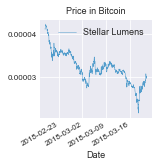

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize=(2,2))
plt.plot(xlm.close_time,xlm.close_price , color = '#539dcc', label ='Stellar Lumens', linewidth = 0.5)
plt.title('Price in Bitcoin',fontsize = 9)
plt.xlabel('Date',fontsize = 9)
plt.legend(loc='best',fontsize = 9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.gcf().autofmt_xdate()

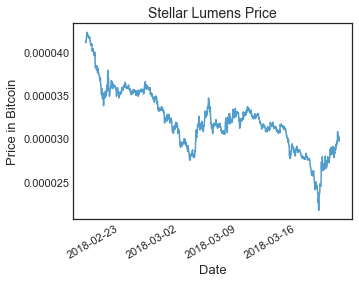

In [7]:
sns.set_style('white')
plt.figure(figsize=(5,4))
plt.plot(xlm.close_time,xlm.close_price , color = '#539dcc', linewidth = 1.5)
plt.title('Stellar Lumens Price',fontsize = 14)
plt.xlabel('Date',fontsize = 13)
plt.ylabel('Price in Bitcoin',fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.gcf().autofmt_xdate()

In [8]:
#checking the disparity in number of records
print(xlm.close_time.min()) 
print(xlm.close_time.max()) 

2018-02-18 21:00:00
2018-03-21 00:30:00


In [9]:
xlm.columns

Index(['coin', 'close_price', 'close_time', 'tweet_time', 'num_tweets',
       'fav_percent', 'retweet_percent', 'avg_senti', 'min_senti',
       'max_senti'],
      dtype='object')

In [10]:
# create log returns column
xlm["close_log_return"] = np.log(xlm.close_price / xlm.close_price.shift(1)) # log of (current price divided by previous price)


In [11]:
# create raw returns column
xlm["close_raw_return"] = (xlm.close_price / xlm.close_price.shift(1))-1 # raw return

In [12]:
print(xlm.close_raw_return.mean())

-0.00018941715113433778


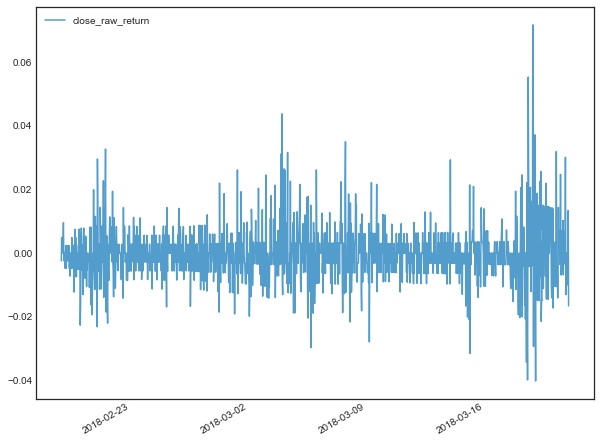

In [13]:
plt.figure(figsize=(10,8))
plt.plot(xlm.close_time,xlm.close_raw_return , color = '#539dcc')
plt.legend(loc='best')
plt.gcf().autofmt_xdate()

In [14]:
# create target
conditions = [
    (xlm['close_raw_return'] > 0) ,
    (xlm['close_raw_return'] <= 0)]
choices = [1, 0]
xlm['target'] = np.select(conditions, choices, default=0)

In [15]:
print(xlm[['close_raw_return', 'target']])

      close_raw_return  target
0                  NaN       0
1            -0.002427       0
2             0.004866       1
3             0.000000       0
4             0.004843       1
5             0.004819       1
6             0.004796       1
7             0.009547       1
8             0.000000       0
9            -0.002364       0
10            0.000000       0
11           -0.002370       0
12           -0.004751       0
13            0.000000       0
14            0.002387       1
15           -0.004762       0
16            0.000000       0
17           -0.002392       0
18            0.002398       1
19            0.000000       0
20           -0.002392       0
21           -0.002398       0
22            0.002404       1
23            0.002398       1
24           -0.004785       0
25            0.000000       0
26           -0.007212       0
27            0.000000       0
28           -0.004843       0
29           -0.004866       0
...                ...     ...
1418    

In [16]:
print(xlm.target.agg('sum') ,xlm.target.agg('count'))

517 1448


In [17]:
# refine dataframes
xlm = xlm[['coin','target','close_time','close_raw_return','tweet_time', 'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti', 'max_senti' , 'min_senti']]

# drop NA (this the first row which can't calculate close_return as there is no previous close_price to calculate using)
xlm = xlm.dropna()
#reset the index
xlm = xlm.reset_index(drop='True')

#cast to float
xlm.max_senti = xlm.max_senti.astype(float)
xlm.min_senti = xlm.min_senti.astype(float)
xlm.fav_percent = xlm.fav_percent.astype(float)
xlm.retweet_percent = xlm.retweet_percent.astype(float)

In [18]:
xlm.dtypes

coin                        object
target                       int32
close_time          datetime64[ns]
close_raw_return           float64
tweet_time          datetime64[ns]
num_tweets                   int64
fav_percent                float64
retweet_percent            float64
avg_senti                  float64
max_senti                  float64
min_senti                  float64
dtype: object

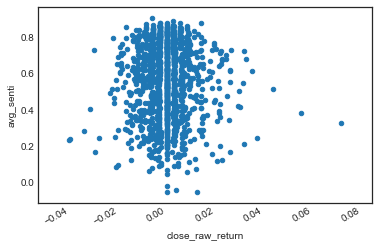

In [19]:
plt.figure(figsize=(10,8))
xlm.plot.scatter(x='close_raw_return',y = 'avg_senti')
plt.legend(loc='best')
plt.gcf().autofmt_xdate()

In [20]:
xlm.columns

Index(['coin', 'target', 'close_time', 'close_raw_return', 'tweet_time',
       'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti'],
      dtype='object')

In [21]:
xlm = xlm[['coin','target', 'close_time', 'close_raw_return', 'tweet_time', 'num_tweets',
       'fav_percent', 'retweet_percent', 'avg_senti', 'max_senti',
       'min_senti']]

In [22]:
print(xlm.close_raw_return.head(10), xlm.close_raw_return.rolling(min_periods=4, window=4).mean().shift(1).head(8))
#xlm.avg_senti.rolling(min_periods=6, window=6).mean().shift(1).head(8)

0   -0.002427
1    0.004866
2    0.000000
3    0.004843
4    0.004819
5    0.004796
6    0.009547
7    0.000000
8   -0.002364
9    0.000000
Name: close_raw_return, dtype: float64 0         NaN
1         NaN
2         NaN
3         NaN
4    0.001820
5    0.003632
6    0.003615
7    0.006001
Name: close_raw_return, dtype: float64


In [23]:
# create additional variables
# based on return
xlm['avg_return_L2h'] = xlm.close_raw_return.rolling(min_periods=4, window=4).mean().shift(1) # avg returns for 2 hours before t where t is current time period
xlm['avg_return_L6h'] = xlm.close_raw_return.rolling(min_periods=12, window=12).mean().shift(1) # avg returns for 6 hours before t where t is current time period
xlm['avg_return_L12h'] = xlm.close_raw_return.rolling(min_periods=24, window=24).mean().shift(1) # avg returns for 12 hours before t where t is current time period

# based on sentiment
xlm['avg_senti_L2h'] = xlm.avg_senti.rolling(min_periods=4, window=4).mean().shift(1) # avg sentiment for 2 hours before t where t is current time period
xlm['avg_senti_L6h'] = xlm.avg_senti.rolling(min_periods=12, window=12).mean().shift(-1) # avg sentiment for 6 hours before t where t is current time period
xlm['avg_senti_L12h'] = xlm.avg_senti.rolling(min_periods=24, window=24).mean().shift(-1) # avg sentiment for 12 hours before t where t is current time period

In [24]:
xlm[['close_time' , 'target', 'close_raw_return' ,'avg_return_L2h', 'avg_senti' , 'avg_senti_L2h']].head(7)

,close_time,target,close_raw_return,avg_return_L2h,avg_senti,avg_senti_L2h
0,2018-02-18 21:30:00,0,-0.002427,NaN,0.265818,NaN
1,2018-02-18 22:00:00,1,0.004866,NaN,0.482767,NaN
2,2018-02-18 22:30:00,0,0.000000,NaN,0.318133,NaN
3,2018-02-18 23:00:00,1,0.004843,NaN,0.107256,NaN
4,2018-02-18 23:30:00,1,0.004819,0.001820,0.152390,0.293494
5,2018-02-19 00:00:00,1,0.004796,0.003632,0.090300,0.265137
6,2018-02-19 00:30:00,1,0.009547,0.003615,0.225100,0.167020


In [25]:
xlm.columns

Index(['coin', 'target', 'close_time', 'close_raw_return', 'tweet_time',
       'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h'],
      dtype='object')

In [26]:
print("Prevalance in Data Set:",xlm.target.sum() / xlm.target.count(),"")

Prevalance in Data Set: 0.357290946786 


In [27]:
xlm[['coin', 'target', 'close_time', 'tweet_time',
       'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h']]

,coin,target,close_time,tweet_time,num_tweets,fav_percent,retweet_percent,avg_senti,max_senti,min_senti,avg_return_L2h,avg_return_L6h,avg_return_L12h,avg_senti_L2h,avg_senti_L6h,avg_senti_L12h
0,XLMBTC,0,2018-02-18 21:30:00,2018-02-18 21:00:00,11,3.7273,0.3636,0.265818,0.6249,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,XLMBTC,1,2018-02-18 22:00:00,2018-02-18 21:30:00,9,35.2222,33.0000,0.482767,0.9227,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
2,XLMBTC,0,2018-02-18 22:30:00,2018-02-18 22:00:00,15,0.9333,0.2667,0.318133,0.8567,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
3,XLMBTC,1,2018-02-18 23:00:00,2018-02-18 22:30:00,16,1.5625,0.4375,0.107256,0.8777,-0.5374,NaN,NaN,NaN,NaN,NaN,NaN
4,XLMBTC,1,2018-02-18 23:30:00,2018-02-18 23:00:00,10,0.5000,0.3000,0.152390,0.6597,-0.3612,0.001820,NaN,NaN,0.293494,NaN,NaN
5,XLMBTC,1,2018-02-19 00:00:00,2018-02-18 23:30:00,4,0.7500,0.2500,0.090300,0.3612,0.0000,0.003632,NaN,NaN,0.265137,NaN,NaN
6,XLMBTC,1,2018-02-19 00:30:00,2018-02-19 00:00:00,8,0.3750,0.1250,0.225100,0.7579,0.0000,0.003615,NaN,NaN,0.167020,NaN,NaN
7,XLMBTC,0,2018-02-19 01:00:00,2018-02-19 00:30:00,10,2.7000,1.9000,0.200460,0.7223,-0.4003,0.006001,NaN,NaN,0.143762,NaN,NaN
8,XLMBTC,0,2018-02-19 01:30:00,2018-02-19 01:00:00,9,4.5556,0.6667,0.094233,0.9618,-0.3400,0.004790,NaN,NaN,0.167063,NaN,NaN
9,XLMBTC,0,2018-02-19 02:00:00,2018-02-19 01:30:00,45,0.2444,0.0667,0.067173,0.6996,-0.5160,0.002995,NaN,NaN,0.152523,NaN,NaN


# Training and Testing

In [28]:
# train/ test split
xlm_train = xlm.sample(frac=0.7,random_state=200)  
xlm_test = xlm.drop(xlm_train.index)

xlm_train = xlm_train[['target','num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti','max_senti', 'min_senti'
  , 'avg_return_L2h', 'avg_return_L6h', 'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h']]
xlm_test = xlm_test[['target','num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti','max_senti', 'min_senti'
  , 'avg_return_L2h', 'avg_return_L6h', 'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h']]

In [29]:
print("Prevalance in Training Set:",xlm_train.target.sum() / xlm_train.target.count(),"")
print("Prevalance in Testing Set:",xlm_test.target.sum() / xlm_test.target.count(),"")

Prevalance in Training Set: 0.365251727542 
Prevalance in Testing Set: 0.338709677419 


## Check for NaN

In [30]:
print("Number of NaN in Training:",xlm_train.isnull().sum().sum(),", Number of NaN in Testing:", xlm_test.isnull().sum().sum())

Number of NaN in Training: 55 , Number of NaN in Testing: 23


In [31]:
print(xlm_train)

      target  num_tweets  fav_percent  retweet_percent  avg_senti  max_senti  \
1255       1           9       2.1111           0.5556   0.281811     0.9559   
538        1          30       0.3667           0.0667   0.696437     0.9272   
1016       0          13       1.0000           0.3077   0.090754     0.9559   
987        0          23       1.6087           1.1739   0.594061     0.9559   
718        0          52       0.9423           0.5000   0.658150     0.9436   
866        1          23       2.3043           0.6522   0.150343     0.9258   
863        0          18       2.7222           0.5556   0.470839     0.9258   
946        0          14       2.2857           0.8571   0.279157     0.8955   
398        1          64       0.5156           0.4219   0.831752     0.9272   
1127       0          14       0.5714           0.1429   0.423829     0.9559   
1289       0          16       1.0625           0.3750   0.556175     0.9559   
213        0          90       0.5111   

In [32]:
#records that are being dropped are ones that didn't have a sufficient number of records that occurred immediately prior 
#to them in order to create the derived variables i.e. avg_senti_L2h: the first four records in the dataset would have been dropped
xlm_train = xlm_train.dropna()
xlm_test = xlm_test.dropna()
print("Number of NaN in Training:",xlm_train.isnull().sum().sum(),", Number of NaN in Testing:", xlm_test.isnull().sum().sum())

Number of NaN in Training: 0 , Number of NaN in Testing: 0


In [33]:
# reset the index for the training and test so that PCA sets can be merged back
xlm_train = xlm_train.reset_index(drop=True)
xlm_test = xlm_test.reset_index(drop=True)

### More Feature Creation

In [34]:
xlm_train.num_tweets.quantile(.9)

84.60000000000002

In [35]:
#top decile
quant90tr = []
quant90tst = []

for t in xlm_train.num_tweets:
     if t > xlm_train.num_tweets.quantile(.90):
            quant90tr.append(1)
     else:
            quant90tr.append(0)
            

for t in xlm_test.num_tweets:
     if t > xlm_train.num_tweets.quantile(.90):#uses the training quartile to determine its value as test data is for validation only
            quant90tst.append(1)
     else:
            quant90tst.append(0)            
                
xlm_train = pd.merge(xlm_train, pd.DataFrame(quant90tr), left_index=True, right_index=True)                             
xlm_test = pd.merge(xlm_test, pd.DataFrame(quant90tst), left_index=True, right_index=True)                       

In [36]:
#top quartile
quant75tr = []
quant75tst = []

for t in xlm_train.num_tweets:
     if t > xlm_train.num_tweets.quantile(.75):
            quant75tr.append(1)
     else:
            quant75tr.append(0)
            

for t in xlm_test.num_tweets:
     if t > xlm_train.num_tweets.quantile(.75):#uses the training quartile to determine its value as test data is for validation only
            quant75tst.append(1)
     else:
            quant75tst.append(0)            
            
xlm_train = pd.merge(xlm_train, pd.DataFrame(quant75tr), left_index=True, right_index=True)                             
xlm_test = pd.merge(xlm_test, pd.DataFrame(quant75tst), left_index=True, right_index=True)                

In [37]:
xlm_train.columns = ['target', 'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'top_decile_num_tweets', 'top_quartile_num_tweets']
xlm_test.columns = ['target', 'num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'top_decile_num_tweets', 'top_quartile_num_tweets']
print(xlm_train, xlm_test)

     target  num_tweets  fav_percent  retweet_percent  avg_senti  max_senti  \
0         1           9       2.1111           0.5556   0.281811     0.9559   
1         1          30       0.3667           0.0667   0.696437     0.9272   
2         0          13       1.0000           0.3077   0.090754     0.9559   
3         0          23       1.6087           1.1739   0.594061     0.9559   
4         0          52       0.9423           0.5000   0.658150     0.9436   
5         1          23       2.3043           0.6522   0.150343     0.9258   
6         0          18       2.7222           0.5556   0.470839     0.9258   
7         0          14       2.2857           0.8571   0.279157     0.8955   
8         1          64       0.5156           0.4219   0.831752     0.9272   
9         0          14       0.5714           0.1429   0.423829     0.9559   
10        0          16       1.0625           0.3750   0.556175     0.9559   
11        0          90       0.5111           0.433

In [38]:
print('top Decile tweets in train:',xlm_train.top_decile_num_tweets.agg('sum') , 'top Decile tweets in test:',xlm_test.top_decile_num_tweets.agg('sum'))

top Decile tweets in train: 100 top Decile tweets in test: 44


### Scale Variables

In [39]:
scaler = sklearn.preprocessing.MinMaxScaler() #scaler

#scaling
xlm_train1 = xlm_train[xlm_train.columns.difference(['target'])]

xlm_scaled_tr = pd.DataFrame(scaler.fit_transform(xlm_train1))
xlm_scaled_tr.columns = xlm_train1.columns
xlm_scaled_tr.index = xlm_train1.index
print(xlm_scaled_tr)

     avg_return_L12h  avg_return_L2h  avg_return_L6h  avg_senti  \
0           0.349856        0.423288        0.448777   0.349696   
1           0.143014        0.112466        0.232924   0.778180   
2           0.317457        0.403682        0.475732   0.152253   
3           0.382035        0.385388        0.463003   0.672382   
4           0.277427        0.306817        0.217514   0.738614   
5           0.338669        0.423437        0.417318   0.213834   
6           0.464598        0.423610        0.511716   0.545042   
7           0.355566        0.461602        0.428087   0.346953   
8           0.314743        0.423778        0.440822   0.918017   
9           0.430064        0.403368        0.450462   0.496460   
10          0.174519        0.256978        0.202728   0.633230   
11          0.440193        0.388428        0.507129   0.914081   
12          0.228434        0.423462        0.271720   0.282465   
13          0.435946        0.445275        0.642217   0.58623

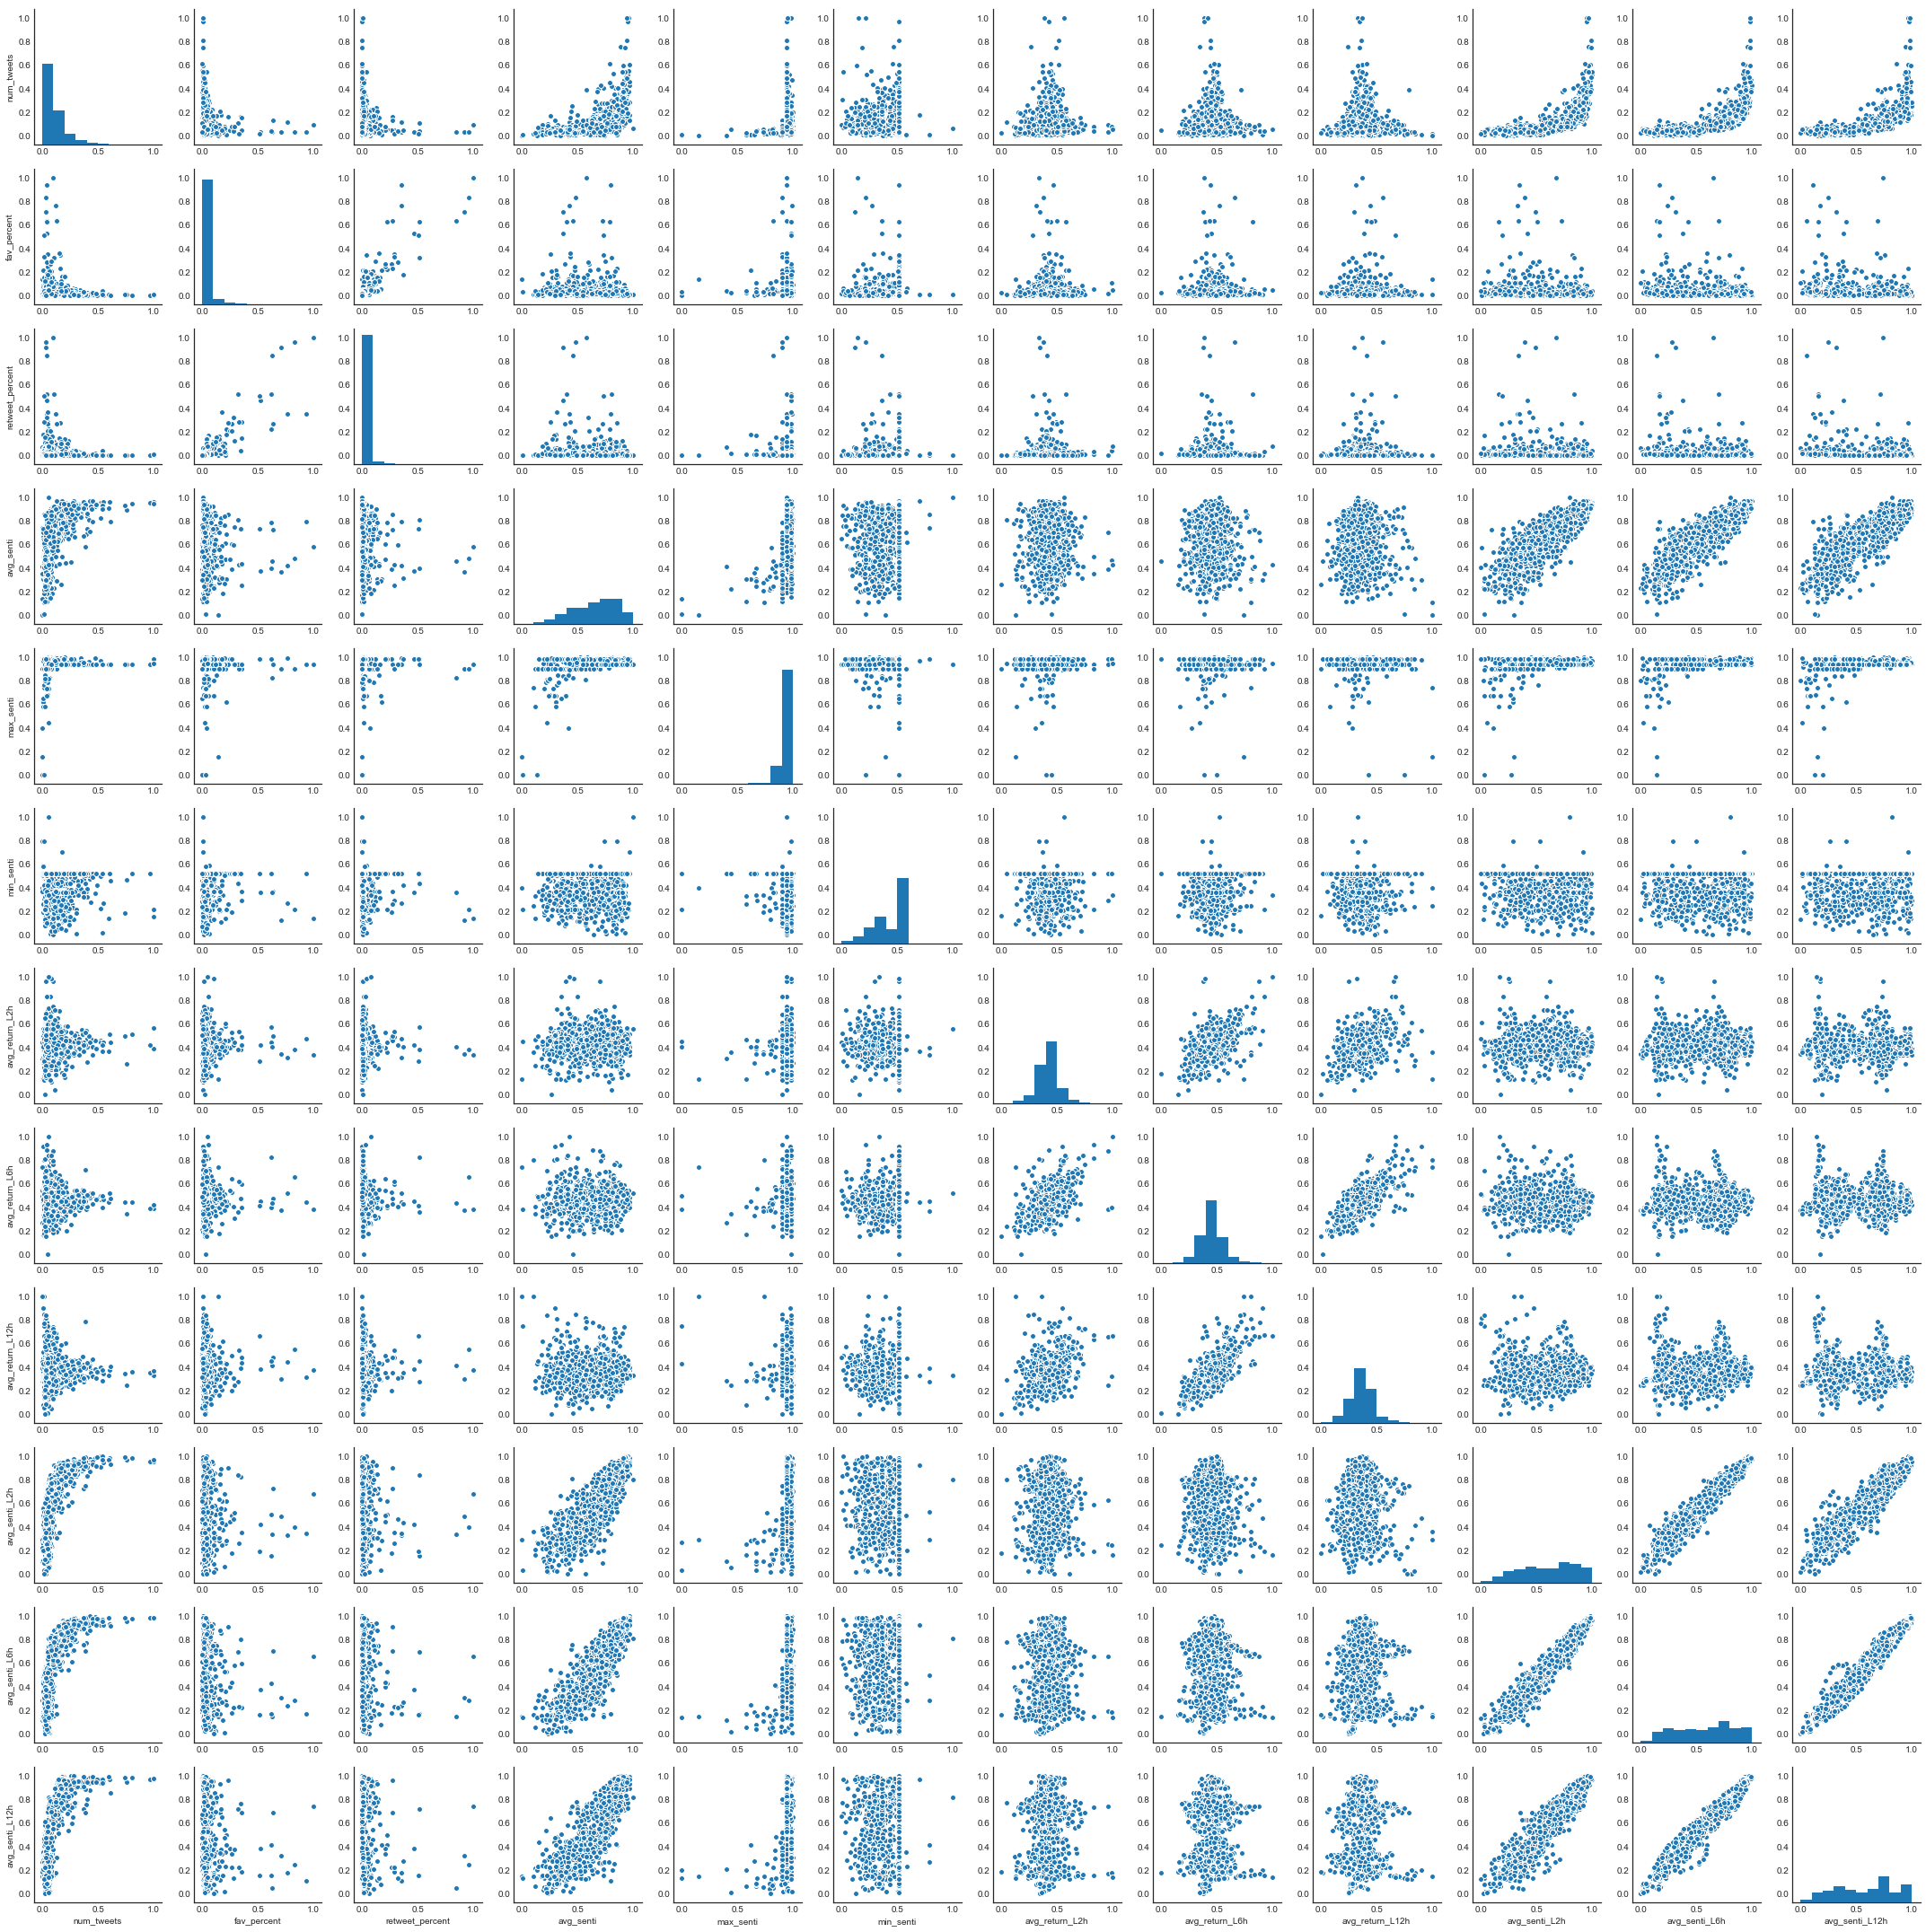

In [40]:
#example of how some of the variables are correlated in the fundamentals dataset
sns.pairplot(xlm_scaled_tr[['num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h']])
plt.show()

In [41]:
#don't include categorical cols or cols with ~25% NaN in imputation and PCA 
xlm_test1 = xlm_test[xlm_test.columns.difference(['target'])]

xlm_scaled_tst = pd.DataFrame(scaler.transform(xlm_test1))
xlm_scaled_tst.columns = xlm_test1.columns
xlm_scaled_tst.index = xlm_test1.index
xlm_scaled_tr= pd.merge(xlm_train[['target']], xlm_scaled_tr, left_index=True, right_index=True)
print(xlm_scaled_tst)

     avg_return_L12h  avg_return_L2h  avg_return_L6h  avg_senti  \
0           0.381587        0.348002        0.416049   0.384225   
1           0.324755        0.317132        0.387614   0.166828   
2           0.310607        0.408028        0.396984   0.316710   
3           0.274740        0.346680        0.349473   0.260859   
4           0.258611        0.376071        0.414311   0.489546   
5           0.295045        0.454987        0.414679   0.563923   
6           0.228453        0.313304        0.317006   0.572604   
7           0.211176        0.456589        0.383109   0.687941   
8           0.217561        0.390598        0.422653   0.613912   
9           0.231724        0.440403        0.402339   0.746523   
10          0.201287        0.324132        0.401669   0.523830   
11          0.272779        0.322228        0.379683   0.689779   
12          0.249541        0.339177        0.317916   0.778251   
13          0.281164        0.457832        0.390488   0.72166

### Univariate Analysis

In [42]:
#no negative values
sum(n < 0 for n in xlm_scaled_tr[['num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'top_decile_num_tweets', 'top_quartile_num_tweets']].values.flatten())

0

In [43]:
univar_tr_target = xlm_train[['target']].values
univar_tr_data = xlm_scaled_tr[['num_tweets', 'fav_percent', 'retweet_percent', 'avg_senti',
       'max_senti', 'min_senti', 'avg_return_L2h', 'avg_return_L6h',
       'avg_return_L12h', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'top_decile_num_tweets', 'top_quartile_num_tweets']].values
univar = SelectKBest(score_func=chi2, k=4)
fit_univar = univar.fit(univar_tr_data, univar_tr_target)
# summarize scores
np.set_printoptions(precision=3)
print(fit_univar.scores_)
univar_features = fit_univar.transform(univar_tr_data)
# summarize selected features
print(xlm_scaled_tr.columns)

[  5.589e-02   1.279e-02   1.866e-04   5.260e-04   5.221e-03   7.188e-02
   5.275e-02   2.622e-02   1.620e-02   1.554e-04   2.788e-02   1.925e-03
   2.961e-01   1.339e-01]
Index(['target', 'avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets'],
      dtype='object')


### Variable Distributions

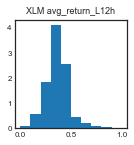

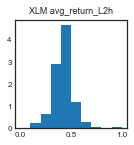

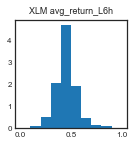

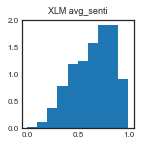

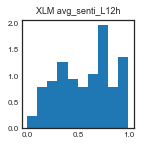

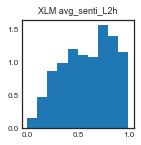

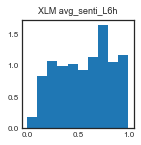

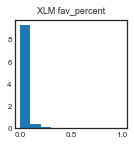

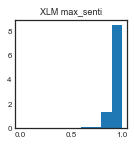

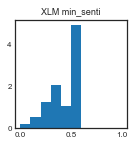

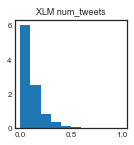

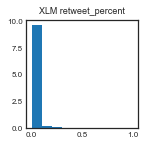

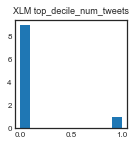

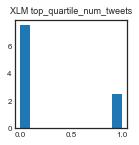

In [44]:
for i in ('avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h','avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
'fav_percent', 'max_senti', 'min_senti', 'num_tweets','retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets'):
    plt.figure(figsize=(2,2))
    plt.title('XLM %s'%i, fontsize = 9)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.hist(xlm_scaled_tr[i], normed=True)

### Correlation Matrix

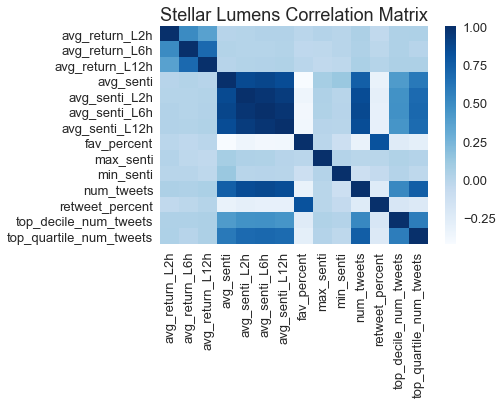

In [45]:
corr = xlm_scaled_tr[['avg_return_L2h', 'avg_return_L6h', 'avg_return_L12h',
       'avg_senti', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']].corr('spearman') #used Spearman as some vars not not normally distributed

sns.set(font_scale=1.3)
ax = plt.axes()
sns.heatmap(corr,  
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap='Blues', ax=ax)
ax.set_title('Stellar Lumens Correlation Matrix', fontsize=18)
plt.show()

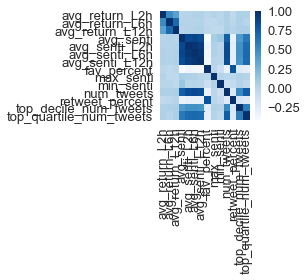

In [46]:
corr = xlm_scaled_tr[['avg_return_L2h', 'avg_return_L6h', 'avg_return_L12h',
       'avg_senti', 'avg_senti_L2h', 'avg_senti_L6h', 'avg_senti_L12h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']].corr('spearman') #used Spearman as some vars not not normally distributed

fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(corr,  
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="Blues", ax=ax)

## PCA

Text(0,0.5,'Cum. Explained Variance')

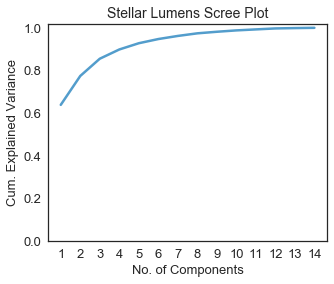

In [48]:
pca = PCA().fit(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']])
PCA_chk = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
PCA_chk['rule'] = PCA_chk.index+1
PCA_chk.columns = ['cum_var' , 'PC']

#graph
sns.set_style('white')
plt.figure(figsize=(5,4))
plt.title('Stellar Lumens Scree Plot', fontsize = 14)
plt.xticks(np.arange(min(PCA_chk['PC']), max(PCA_chk['PC'])+1, 1.0),fontsize = 13)
plt.yticks(fontsize = 13)
plt.plot(PCA_chk['PC'],PCA_chk['cum_var'], color = '#539dcc', linewidth = 2.5)
plt.ylim(ymin=0)
plt.xlabel('No. of Components',fontsize = 13)
plt.ylabel('Cum. Explained Variance',fontsize = 13)

In [46]:
# elbow appears to be at 4/5 Principle Components
PCA_chk.to_csv('XLM PCA_rule_variant.csv')

#### Include Sentiment and Tweet Features

#### Fit PCA to Training & Apply to Training & Test Set

In [49]:
pca = PCA(n_components = 5) #account for 92% of variance
pca.fit(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']])

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
xlm_train1 = pd.DataFrame(pca.transform(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]))
xlm_test1 = pd.DataFrame(pca.transform(xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]))

In [51]:
#rename PCA cols
for c in xlm_train1.columns:
    d = c+1                        #PCA and index + 1 as name
    xlm_train1['PC%s'% d] = xlm_train1[c]

#drop duplicate cols
xlm_train1 = xlm_train1.filter(like='PC',axis=1)

In [52]:
#rename PCA cols
for c in xlm_test1.columns:
    d = c+1                       #PCA and index + 1 as name
    xlm_test1['PC%s'% d] = xlm_test1[c]

#drop duplicate cols
xlm_test1 = xlm_test1.filter(like='PC',axis=1)

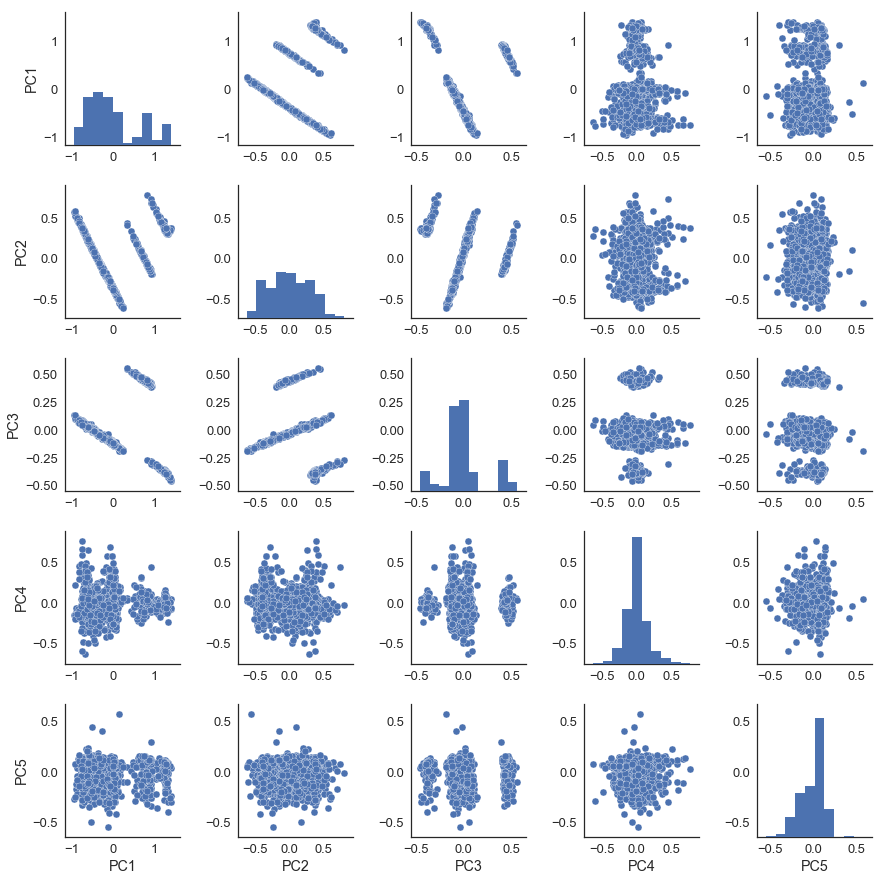

In [53]:
sns.pairplot(xlm_train1)
plt.show()

In [54]:
#merge PCA back to fundamentals
xlm_trainPCA = pd.merge(xlm_train[['target']], xlm_train1, left_index=True, right_index=True)
xlm_testPCA = pd.merge(xlm_test[['target']], xlm_test1, left_index=True, right_index=True)

#### Exclude Sentiment and Tweet Features

Text(0,0.5,'cumulative explained variance')

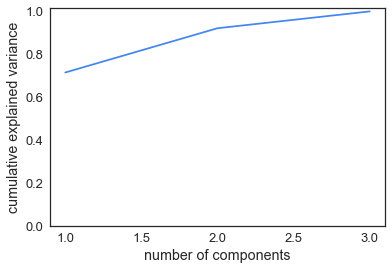

In [55]:
pca = PCA().fit(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']])
PCA_chk = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
PCA_chk['rule'] = PCA_chk.index+1
PCA_chk.columns = ['cum_var' , 'PC']

#graph
plt.plot(PCA_chk['PC'],PCA_chk['cum_var'], c= '#4286f4')
plt.ylim(ymin=0)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [71]:
# elbow appears to be at 2 Principle Components
PCA_chk.to_csv('XLM PCA_rule_variant_no_tweet_data.csv')

#### Fit PCA to Training & Apply to Training & Test Set

In [56]:
pca = PCA(n_components = 2) #account for 92% of variance
pca.fit(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
xlm_train_no_tweet_1 = pd.DataFrame(pca.transform(xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]))
xlm_test_no_tweet_1 = pd.DataFrame(pca.transform(xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]))

In [58]:
#rename PCA cols
for c in xlm_train_no_tweet_1.columns:
    d = c+1                        #PCA and index + 1 as name
    xlm_train_no_tweet_1['PC%s'% d] = xlm_train_no_tweet_1[c]

#drop duplicate cols
xlm_train_no_tweet_1 = xlm_train_no_tweet_1.filter(like='PC',axis=1)

In [59]:
#rename PCA cols
for c in xlm_test_no_tweet_1.columns:
    d = c+1                       #PCA and index + 1 as name
    xlm_test_no_tweet_1['PC%s'% d] = xlm_test_no_tweet_1[c]

#drop duplicate cols
xlm_test_no_tweet_1 = xlm_test_no_tweet_1.filter(like='PC',axis=1)

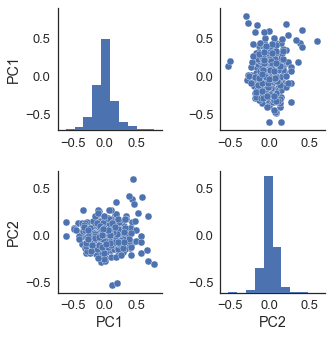

In [60]:
sns.pairplot(xlm_train_no_tweet_1)
plt.show()

In [61]:
#merge PCA back to fundamentals
xlm_train_no_tweet_PCA = pd.merge(xlm_train[['target']], xlm_train_no_tweet_1, left_index=True, right_index=True)
xlm_test_no_tweet_PCA = pd.merge(xlm_test[['target']], xlm_test_no_tweet_1, left_index=True, right_index=True)

# Machine Learning

In [62]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model as lm 
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn import svm 
from sklearn import naive_bayes as nb
from patsy import dmatrices
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn import calibration

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [63]:
print(xlm_trainPCA)
print(xlm_train_no_tweet_PCA)

     target       PC1       PC2       PC3       PC4       PC5
0         1 -0.533139  0.162757  0.029306  0.000962 -0.215998
1         1 -0.160962 -0.227945 -0.079225 -0.418598  0.086665
2         0 -0.588623  0.225500  0.037649 -0.017034 -0.114632
3         0 -0.280610 -0.099084 -0.055456 -0.006323  0.108864
4         0  0.057476 -0.416731 -0.124999 -0.234010 -0.107248
5         1 -0.462508  0.110482  0.016043 -0.013996 -0.271436
6         0 -0.282292 -0.089920 -0.050155  0.101580  0.074015
7         0 -0.558117  0.190004  0.025109 -0.006854 -0.047553
8         1  0.777903 -0.026730  0.436842 -0.044847  0.147630
9         0 -0.523325  0.147673  0.012341  0.025430 -0.031727
10        0 -0.496265  0.107124  0.015106 -0.349329 -0.130727
11        0  1.254059  0.362689 -0.372883  0.044436  0.101393
12        1 -0.775955  0.398662  0.075554 -0.214147  0.033466
13        0 -0.445413  0.093265 -0.000065  0.188039 -0.298576
14        0 -0.778842  0.421789  0.087889 -0.019346 -0.255260
15      

In [64]:
print(xlm_testPCA.isnull().sum().sum())
print(xlm_test_no_tweet_PCA.isnull().sum().sum())

0
0


In [65]:
#records that are being dropped are ones that didn't have a sufficient number of records that occurred immediately prior 
#to them in order to create the derived variables i.e. avg_senti_L12h
xlm_train = xlm_train.dropna()
xlm_test = xlm_test.dropna()
print("Number of NaN in Training:",xlm_train.isnull().sum().sum(),", Number of NaN in Testing:", xlm_test.isnull().sum().sum())

Number of NaN in Training: 0 , Number of NaN in Testing: 0


In [66]:
print(xlm_trainPCA.columns)
print(xlm_train_no_tweet_PCA.columns)

Index(['target', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'], dtype='object')
Index(['target', 'PC1', 'PC2'], dtype='object')


In [67]:
data_cols = pd.DataFrame(columns = ['PC1', 'PC2', 'PC3', 'PC4' , 'PC5'])  #columns for modelling
#convert train/ test to matrices for modelling
xlm_data_train = xlm_trainPCA.as_matrix(columns=[ list(data_cols) ])
xlm_target_train = xlm_trainPCA.as_matrix(columns=['target'])
xlm_target_train = np.ravel(xlm_target_train)

xlm_data_test = xlm_testPCA.as_matrix(columns=[ list(data_cols) ])
xlm_target_test = xlm_testPCA.as_matrix(columns=['target'])
xlm_target_test = np.ravel(xlm_target_test)

In [68]:
data_cols_no_tweet = pd.DataFrame(columns = ['PC1', 'PC2'])  #columns for modelling
#convert train/ test to matrices for modelling
xlm_data_no_tweet_train = xlm_train_no_tweet_PCA.as_matrix(columns=[ list(data_cols_no_tweet) ])

xlm_data_no_tweet_test = xlm_test_no_tweet_PCA.as_matrix(columns=[ list(data_cols_no_tweet) ])

In [69]:
pd.DataFrame(xlm_target_train).sum() / pd.DataFrame(xlm_target_train).count()

0    0.363819
dtype: float64

In [70]:
#xlm_scaled_tr.columns
xlm_scaled_tr.columns.tolist()

['target',
 'avg_return_L12h',
 'avg_return_L2h',
 'avg_return_L6h',
 'avg_senti',
 'avg_senti_L12h',
 'avg_senti_L2h',
 'avg_senti_L6h',
 'fav_percent',
 'max_senti',
 'min_senti',
 'num_tweets',
 'retweet_percent',
 'top_decile_num_tweets',
 'top_quartile_num_tweets']

In [71]:
#tweets
xlm_scaled_tr = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]

xlm_scaled_tr = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h',
       'avg_senti', 'avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h',
       'fav_percent', 'max_senti', 'min_senti', 'num_tweets',
       'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]

xlm_trainPCA = xlm_trainPCA[['PC1' , 'PC2', 'PC3' ,'PC4', 'PC5']]
xlm_testPCA = xlm_testPCA[['PC1' , 'PC2', 'PC3' ,'PC4', 'PC5']]


#no tweets
xlm_scaled_no_tweet_tr = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]

xlm_scaled_no_tweet_tst = xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]

xlm_train_no_tweet_PCA = xlm_train_no_tweet_PCA[['PC1' , 'PC2']]
xlm_test_no_tweet_PCA = xlm_test_no_tweet_PCA[['PC1' , 'PC2']]

## Parameter & Feature Selection

### Logisitic Regression: Parameter and Feature Investigation

#### With Tweet Data

In [88]:
for X in (xlm_scaled_tr ,xlm_trainPCA):
     for solv in ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'):
            for c in (.001, 0.1, 1, 10, 100):
                #Recursive Feature Elimination
                model_RFE_lr = lm.LogisticRegression(C = c,solver = solv, class_weight = 'balanced')
                # create the RFECV model
                rfe_lr = RFECV(model_RFE_lr, step=1, scoring='roc_auc')   #'roc_auc' 
                rfe_lr = rfe_lr.fit(X, xlm_target_train)
                result_lr = rfe_lr.support_
                rank_lr = rfe_lr.ranking_
                RFE_cols_lr = pd.DataFrame(result_lr, columns = ['Keep'])
                RFE_rank_lr = pd.DataFrame(rank_lr, columns = ['Rank'])
                data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                RFE_cols_lr['indexs'] = RFE_cols_lr.index
                RFE_rank_lr['indexs'] = RFE_rank_lr.index
                data_cols_df['indexs'] = data_cols_df.index
                keep_vars_lr = pd.merge(data_cols_df, RFE_cols_lr , on=['indexs'])
                keep_vars_lr = pd.merge(keep_vars_lr, RFE_rank_lr , on=['indexs'])
                keep_vars_lr = keep_vars_lr.drop('indexs', axis=1)
                matr=confusion_matrix(xlm_target_train, rfe_lr.predict(X)).ravel()
                print("C=",c,"Algorithm=",solv, "ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_lr.predict_proba(X)[:, 1]), keep_vars_lr[:25],metrics.classification_report(xlm_target_train, rfe_lr.predict(X)))

C= 0.001 Algorithm= newton-cg ROC: 0.531447199602                    Variable   Keep  Rank
0           avg_return_L12h  False     5
1            avg_return_L2h  False     2
2            avg_return_L6h  False     4
3                 avg_senti  False    10
4            avg_senti_L12h  False     8
5             avg_senti_L2h  False    11
6             avg_senti_L6h  False     3
7               fav_percent  False     9
8                 max_senti  False     7
9                 min_senti   True     1
10               num_tweets  False     6
11          retweet_percent  False    12
12    top_decile_num_tweets   True     1
13  top_quartile_num_tweets   True     1              precision    recall  f1-score   support

          0       0.64      0.75      0.69       633
          1       0.37      0.26      0.31       362

avg / total       0.54      0.57      0.55       995

C= 0.1 Algorithm= newton-cg ROC: 0.545254990268                    Variable   Keep  Rank
0           avg_return_L12h  Fa

C= 0.001 Algorithm= liblinear ROC: 0.530273275554                    Variable   Keep  Rank
0           avg_return_L12h  False     2
1            avg_return_L2h   True     1
2            avg_return_L6h   True     1
3                 avg_senti  False     6
4            avg_senti_L12h  False     4
5             avg_senti_L2h  False     7
6             avg_senti_L6h   True     1
7               fav_percent  False     5
8                 max_senti  False     3
9                 min_senti   True     1
10               num_tweets   True     1
11          retweet_percent  False     8
12    top_decile_num_tweets   True     1
13  top_quartile_num_tweets   True     1              precision    recall  f1-score   support

          0       0.64      0.75      0.69       633
          1       0.37      0.26      0.30       362

avg / total       0.54      0.57      0.55       995

C= 0.1 Algorithm= liblinear ROC: 0.548032695312                    Variable   Keep  Rank
0           avg_return_L12h  Fa

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C= 100 Algorithm= sag ROC: 0.561358260672                    Variable   Keep  Rank
0           avg_return_L12h  False     8
1            avg_return_L2h   True     1
2            avg_return_L6h  False     9
3                 avg_senti  False     2
4            avg_senti_L12h   True     1
5             avg_senti_L2h   True     1
6             avg_senti_L6h   True     1
7               fav_percent  False     3
8                 max_senti   True     1
9                 min_senti  False     5
10               num_tweets  False     6
11          retweet_percent  False     4
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False    10              precision    recall  f1-score   support

          0       0.67      0.52      0.59       633
          1       0.40      0.56      0.46       362

avg / total       0.57      0.53      0.54       995

C= 0.001 Algorithm= saga ROC: 0.531447199602                    Variable   Keep  Rank
0           avg_return_L12h  False     5
1

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C= 10 Algorithm= saga ROC: 0.553463730547                    Variable   Keep  Rank
0           avg_return_L12h  False     8
1            avg_return_L2h  False     2
2            avg_return_L6h  False    10
3                 avg_senti  False     4
4            avg_senti_L12h   True     1
5             avg_senti_L2h   True     1
6             avg_senti_L6h   True     1
7               fav_percent  False     5
8                 max_senti   True     1
9                 min_senti  False     3
10               num_tweets  False     7
11          retweet_percent  False     6
12    top_decile_num_tweets  False     9
13  top_quartile_num_tweets  False    11              precision    recall  f1-score   support

          0       0.68      0.51      0.58       633
          1       0.40      0.57      0.47       362

avg / total       0.58      0.53      0.54       995



C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\niall\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C= 100 Algorithm= saga ROC: 0.561362624702                    Variable   Keep  Rank
0           avg_return_L12h  False     8
1            avg_return_L2h   True     1
2            avg_return_L6h  False     9
3                 avg_senti  False     2
4            avg_senti_L12h   True     1
5             avg_senti_L2h   True     1
6             avg_senti_L6h   True     1
7               fav_percent  False     3
8                 max_senti   True     1
9                 min_senti  False     5
10               num_tweets  False     6
11          retweet_percent  False     4
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False    10              precision    recall  f1-score   support

          0       0.67      0.52      0.59       633
          1       0.40      0.56      0.46       362

avg / total       0.57      0.53      0.54       995

C= 0.001 Algorithm= newton-cg ROC: 0.504477494698   Variable   Keep  Rank
0      PC1   True     1
1      PC2  False     4
2    

C= 100 Algorithm= sag ROC: 0.537203355066   Variable   Keep  Rank
0      PC1  False     4
1      PC2  False     3
2      PC3  False     5
3      PC4  False     2
4      PC5   True     1              precision    recall  f1-score   support

          0       0.66      0.60      0.63       633
          1       0.40      0.45      0.42       362

avg / total       0.56      0.55      0.55       995

C= 0.001 Algorithm= saga ROC: 0.504477494698   Variable   Keep  Rank
0      PC1   True     1
1      PC2  False     4
2      PC3  False     5
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.65      0.64      0.65       633
          1       0.39      0.40      0.39       362

avg / total       0.56      0.55      0.55       995

C= 0.1 Algorithm= saga ROC: 0.537203355066   Variable   Keep  Rank
0      PC1  False     4
1      PC2  False     3
2      PC3  False     5
3      PC4  False     2
4      PC5   True     1         

#### Without Tweet Data

In [89]:
for X in (xlm_scaled_no_tweet_tr ,xlm_train_no_tweet_PCA):
     for solv in ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'):
            for c in (.001, 0.1, 1, 10, 100):
                #Recursive Feature Elimination
                model_RFE_lr = lm.LogisticRegression(C = c,solver = solv,class_weight = 'balanced')
                # create the RFECV model
                rfe_lr = RFECV(model_RFE_lr, step=1, scoring='roc_auc')   #'roc_auc' 
                rfe_lr = rfe_lr.fit(X, xlm_target_train)
                result_lr = rfe_lr.support_
                rank_lr = rfe_lr.ranking_
                RFE_cols_lr = pd.DataFrame(result_lr, columns = ['Keep'])
                RFE_rank_lr = pd.DataFrame(rank_lr, columns = ['Rank'])
                data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                RFE_cols_lr['indexs'] = RFE_cols_lr.index
                RFE_rank_lr['indexs'] = RFE_rank_lr.index
                data_cols_df['indexs'] = data_cols_df.index
                keep_vars_lr = pd.merge(data_cols_df, RFE_cols_lr , on=['indexs'])
                keep_vars_lr = pd.merge(keep_vars_lr, RFE_rank_lr , on=['indexs'])
                keep_vars_lr = keep_vars_lr.drop('indexs', axis=1)
                matr=confusion_matrix(xlm_target_train, rfe_lr.predict(X)).ravel()
                print("C=",c,"Algorithm=",solv, "ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_lr.predict_proba(X)[:, 1]), keep_vars_lr[:25],metrics.classification_report(xlm_target_train, rfe_lr.predict(X)))

C= 0.001 Algorithm= newton-cg ROC: 0.53672549379           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

          0       0.65      0.53      0.59       633
          1       0.38      0.51      0.44       362

avg / total       0.56      0.52      0.53       995

C= 0.1 Algorithm= newton-cg ROC: 0.53672549379           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

          0       0.65      0.53      0.59       633
          1       0.38      0.51      0.44       362

avg / total       0.56      0.52      0.53       995

C= 1 Algorithm= newton-cg ROC: 0.536727675805           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score  

C= 1 Algorithm= saga ROC: 0.536727675805           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

          0       0.65      0.53      0.59       633
          1       0.38      0.51      0.44       362

avg / total       0.56      0.52      0.53       995

C= 10 Algorithm= saga ROC: 0.536727675805           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

          0       0.65      0.53      0.59       633
          1       0.38      0.51      0.44       362

avg / total       0.56      0.52      0.53       995

C= 100 Algorithm= saga ROC: 0.536727675805           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

      

C= 100 Algorithm= saga ROC: 0.52554703115   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1              precision    recall  f1-score   support

          0       0.65      0.52      0.58       633
          1       0.37      0.50      0.43       362

avg / total       0.55      0.51      0.52       995



### Logistic Regression Training & Test Set

#### With Tweet Data

In [72]:
xlm_data_lr_tr2 = xlm_scaled_tr[[ 'avg_return_L2h',  'avg_senti_L2h', 'avg_senti_L6h', 'max_senti', 'min_senti']]
xlm_data_lr_tst2 = xlm_scaled_tst[[ 'avg_return_L2h',  'avg_senti_L2h', 'avg_senti_L6h', 'max_senti', 'min_senti']]


xlm_data_lr_tr3 = xlm_trainPCA[['PC3']]#[['PC2', 'PC3', 'PC5']]
xlm_data_lr_tst3 = xlm_testPCA[['PC3']]#[['PC2', 'PC3', 'PC5']]

#### Without Tweet Data

In [73]:
#scaled raw data
xlm_data_lr_no_tweet_tr2 = xlm_scaled_no_tweet_tr[['avg_return_L2h']]
xlm_data_lr_no_tweet_tst2 = xlm_scaled_no_tweet_tst[[ 'avg_return_L2h']]

#PCA data
xlm_data_lr_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC2']]
xlm_data_lr_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC2']]

### Decision Tree: Parameter and Feature Investigation

#### With Tweet Data

In [78]:
for X in (xlm_scaled_tr, xlm_trainPCA ):
    for c in ('gini' , 'entropy'):
            for depth in (1,5,10,15,20):
                for split in (.1,.2,.3,.4,.5):
                    for leaf in (.1,.2,.3):
                        #Recursive Feature Elimination
                        model_RFE_dt = dt(criterion = c,class_weight = 'balanced'
                                           , max_depth=depth, min_samples_split=split
                                           , min_samples_leaf=leaf)
                        # create the RFECV model
                        rfe_dt = RFECV(model_RFE_dt, step=1, scoring='roc_auc')   #'roc_auc' 
                        rfe_dt = rfe_dt.fit(X, xlm_target_train)
                        result_dt = rfe_dt.support_
                        rank_dt = rfe_dt.ranking_
                        RFE_cols_dt = pd.DataFrame(result_dt, columns = ['Keep'])
                        RFE_rank_dt = pd.DataFrame(rank_dt, columns = ['Rank'])
                        data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                        RFE_cols_dt['indexs'] = RFE_cols_dt.index
                        RFE_rank_dt['indexs'] = RFE_rank_dt.index
                        data_cols_df['indexs'] = data_cols_df.index
                        keep_vars_dt = pd.merge(data_cols_df, RFE_cols_dt , on=['indexs'])
                        keep_vars_dt = pd.merge(keep_vars_dt, RFE_rank_dt , on=['indexs'])
                        keep_vars_dt = keep_vars_dt.drop('indexs', axis=1)
                        matr=confusion_matrix(xlm_target_train, rfe_dt.predict(X)).ravel()
                        print("Criterion=",c, "Max Depth=",depth,"Min Samples Split=",split,"Min Samples Leaf=",leaf, "ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_dt.predict_proba(X)[:, 1]), keep_vars_dt[:25],metrics.classification_report(xlm_target_train, rfe_dt.predict(X)))

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.2 ROC: 0.5497433950

Criterion= gini Max Depth= 1 Min Samples Split= 0.4 Min Samples Leaf= 0.2 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.4 Min Samples Leaf= 0.3 ROC: 0.5497433950

Criterion= gini Max Depth= 5 Min Samples Split= 0.2 Min Samples Leaf= 0.3 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= gini Max Depth= 5 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.5662045158

Criterion= gini Max Depth= 10 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.590424881953                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False     5
2            avg_return_L6h  False     3
3                 avg_senti  False    13
4            avg_senti_L12h   True     1
5             avg_senti_L2h  False    12
6             avg_senti_L6h  False    11
7               fav_percent  False     4
8                 max_senti  False    10
9                 min_senti  False     2
10               num_tweets  False     9
11          retweet_percent  False     8
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False     6              precision    recall  f1-score   support

          0       0.70      0.57      0.63       633
          1       0.44      0.58      0.50       362

avg / total       0.61      0.57      0.58       995

Criterion= gini Max Depth= 10 Min Samples Split= 0.1 Min Samples Leaf= 0.2 

Criterion= gini Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf= 0.1 ROC: 0.578591814825                    Variable   Keep  Rank
0           avg_return_L12h  False    13
1            avg_return_L2h   True     1
2            avg_return_L6h  False     2
3                 avg_senti  False    12
4            avg_senti_L12h  False    11
5             avg_senti_L2h  False    10
6             avg_senti_L6h  False     9
7               fav_percent  False     8
8                 max_senti  False     7
9                 min_senti   True     1
10               num_tweets  False     6
11          retweet_percent  False     5
12    top_decile_num_tweets  False     4
13  top_quartile_num_tweets  False     3              precision    recall  f1-score   support

          0       0.69      0.63      0.66       633
          1       0.43      0.50      0.46       362

avg / total       0.60      0.58      0.59       995

Criterion= gini Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf= 0.2 

Criterion= gini Max Depth= 15 Min Samples Split= 0.2 Min Samples Leaf= 0.1 ROC: 0.590424881953                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False     5
2            avg_return_L6h  False     3
3                 avg_senti  False    13
4            avg_senti_L12h   True     1
5             avg_senti_L2h  False    12
6             avg_senti_L6h  False    11
7               fav_percent  False     4
8                 max_senti  False    10
9                 min_senti  False     2
10               num_tweets  False     9
11          retweet_percent  False     8
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False     6              precision    recall  f1-score   support

          0       0.70      0.57      0.63       633
          1       0.44      0.58      0.50       362

avg / total       0.61      0.57      0.58       995

Criterion= gini Max Depth= 15 Min Samples Split= 0.2 Min Samples Leaf= 0.2 

Criterion= gini Max Depth= 15 Min Samples Split= 0.5 Min Samples Leaf= 0.1 ROC: 0.562927129428                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.72      0.33      0.45       633
          1       0.40      0.78      0.53       362

avg / total       0.60      0.49      0.48       995

Criterion= gini Max Depth= 15 Min Samples Split= 0.5 Min Samples Leaf= 0.2 ROC: 0.54974339

Criterion= gini Max Depth= 20 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.566204515898                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False     3
2            avg_return_L6h  False     2
3                 avg_senti  False    13
4            avg_senti_L12h  False    12
5             avg_senti_L2h  False    11
6             avg_senti_L6h  False    10
7               fav_percent  False     9
8                 max_senti  False     8
9                 min_senti   True     1
10               num_tweets  False     7
11          retweet_percent  False     6
12    top_decile_num_tweets  False     5
13  top_quartile_num_tweets  False     4              precision    recall  f1-score   support

          0       0.68      0.66      0.67       633
          1       0.43      0.46      0.45       362

avg / total       0.59      0.59      0.59       995

Criterion= gini Max Depth= 20 Min Samples Split= 0.3 Min Samples Leaf= 0.2 

Criterion= entropy Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= entropy Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.2 ROC: 0.5497

Criterion= entropy Max Depth= 1 Min Samples Split= 0.4 Min Samples Leaf= 0.2 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= entropy Max Depth= 1 Min Samples Split= 0.4 Min Samples Leaf= 0.3 ROC: 0.5497

Criterion= entropy Max Depth= 5 Min Samples Split= 0.2 Min Samples Leaf= 0.3 ROC: 0.549743395041                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.68      0.55      0.61       633
          1       0.41      0.55      0.47       362

avg / total       0.58      0.55      0.56       995

Criterion= entropy Max Depth= 5 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.5662

Criterion= entropy Max Depth= 10 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.566750019638                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False    13
2            avg_return_L6h  False     5
3                 avg_senti  False    12
4            avg_senti_L12h  False     4
5             avg_senti_L2h  False    11
6             avg_senti_L6h  False     3
7               fav_percent  False     2
8                 max_senti  False    10
9                 min_senti   True     1
10               num_tweets  False     9
11          retweet_percent  False     8
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False     6              precision    recall  f1-score   support

          0       0.68      0.66      0.67       633
          1       0.43      0.46      0.45       362

avg / total       0.59      0.59      0.59       995

Criterion= entropy Max Depth= 10 Min Samples Split= 0.1 Min Samples Leaf

Criterion= entropy Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf= 0.1 ROC: 0.575451895298                    Variable   Keep  Rank
0           avg_return_L12h  False    13
1            avg_return_L2h  False    12
2            avg_return_L6h   True     1
3                 avg_senti  False    11
4            avg_senti_L12h  False    10
5             avg_senti_L2h  False     9
6             avg_senti_L6h  False     8
7               fav_percent  False     7
8                 max_senti  False     6
9                 min_senti   True     1
10               num_tweets  False     5
11          retweet_percent  False     4
12    top_decile_num_tweets  False     3
13  top_quartile_num_tweets  False     2              precision    recall  f1-score   support

          0       0.72      0.33      0.45       633
          1       0.40      0.78      0.53       362

avg / total       0.60      0.49      0.48       995

Criterion= entropy Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf

Criterion= entropy Max Depth= 15 Min Samples Split= 0.2 Min Samples Leaf= 0.1 ROC: 0.566750019638                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False    13
2            avg_return_L6h  False     5
3                 avg_senti  False    12
4            avg_senti_L12h  False     4
5             avg_senti_L2h  False    11
6             avg_senti_L6h  False     3
7               fav_percent  False     2
8                 max_senti  False    10
9                 min_senti   True     1
10               num_tweets  False     9
11          retweet_percent  False     8
12    top_decile_num_tweets  False     7
13  top_quartile_num_tweets  False     6              precision    recall  f1-score   support

          0       0.68      0.66      0.67       633
          1       0.43      0.46      0.45       362

avg / total       0.59      0.59      0.59       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.2 Min Samples Leaf

Criterion= entropy Max Depth= 15 Min Samples Split= 0.5 Min Samples Leaf= 0.1 ROC: 0.562927129428                    Variable  Keep  Rank
0           avg_return_L12h  True     1
1            avg_return_L2h  True     1
2            avg_return_L6h  True     1
3                 avg_senti  True     1
4            avg_senti_L12h  True     1
5             avg_senti_L2h  True     1
6             avg_senti_L6h  True     1
7               fav_percent  True     1
8                 max_senti  True     1
9                 min_senti  True     1
10               num_tweets  True     1
11          retweet_percent  True     1
12    top_decile_num_tweets  True     1
13  top_quartile_num_tweets  True     1              precision    recall  f1-score   support

          0       0.72      0.33      0.45       633
          1       0.40      0.78      0.53       362

avg / total       0.60      0.49      0.48       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.5 Min Samples Leaf= 0.2 ROC: 0.54

Criterion= entropy Max Depth= 20 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.566204515898                    Variable   Keep  Rank
0           avg_return_L12h  False    14
1            avg_return_L2h  False    13
2            avg_return_L6h  False     2
3                 avg_senti  False    12
4            avg_senti_L12h  False     3
5             avg_senti_L2h  False    11
6             avg_senti_L6h  False    10
7               fav_percent  False     9
8                 max_senti  False     8
9                 min_senti   True     1
10               num_tweets  False     7
11          retweet_percent  False     6
12    top_decile_num_tweets  False     5
13  top_quartile_num_tweets  False     4              precision    recall  f1-score   support

          0       0.68      0.66      0.67       633
          1       0.43      0.46      0.45       362

avg / total       0.59      0.59      0.59       995

Criterion= entropy Max Depth= 20 Min Samples Split= 0.3 Min Samples Leaf

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.547321358435   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1
2      PC3  True     1
3      PC4  True     1
4      PC5  True     1              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.2 ROC: 0.547321358435   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1
2      PC3  True     1
3      PC4  True     1
4      PC5  True     1              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 Min Samples Leaf= 0.3 ROC: 0.547321358435   Variable  

Criterion= gini Max Depth= 5 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.577452803016   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     2
2      PC3   True     1
3      PC4  False     4
4      PC5  False     3              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= gini Max Depth= 5 Min Samples Split= 0.3 Min Samples Leaf= 0.2 ROC: 0.570511813429   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= gini Max Depth= 5 Min Samples Split= 0.3 Min Samples Leaf= 0.3 ROC: 0.554759847434 

Criterion= gini Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf= 0.2 ROC: 0.570511813429   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= gini Max Depth= 10 Min Samples Split= 0.4 Min Samples Leaf= 0.3 ROC: 0.554759847434   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     2
4      PC5  False     3              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= gini Max Depth= 10 Min Samples Split= 0.5 Min Samples Leaf= 0.1 ROC: 0.5645985528

Criterion= gini Max Depth= 20 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.60746641879   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1
2      PC3   True     1
3      PC4  False     3
4      PC5   True     1              precision    recall  f1-score   support

          0       0.70      0.62      0.66       633
          1       0.44      0.53      0.48       362

avg / total       0.61      0.59      0.59       995

Criterion= gini Max Depth= 20 Min Samples Split= 0.1 Min Samples Leaf= 0.2 ROC: 0.570511813429   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= gini Max Depth= 20 Min Samples Split= 0.1 Min Samples Leaf= 0.3 ROC: 0.55475984743

Criterion= entropy Max Depth= 1 Min Samples Split= 0.3 Min Samples Leaf= 0.1 ROC: 0.547321358435   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1
2      PC3  True     1
3      PC4  True     1
4      PC5  True     1              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= entropy Max Depth= 1 Min Samples Split= 0.3 Min Samples Leaf= 0.2 ROC: 0.547321358435   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1
2      PC3  True     1
3      PC4  True     1
4      PC5  True     1              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= entropy Max Depth= 1 Min Samples Split= 0.3 Min Samples Leaf= 0.3 ROC: 0.547321358435   V

Criterion= entropy Max Depth= 5 Min Samples Split= 0.4 Min Samples Leaf= 0.3 ROC: 0.554759847434   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     2
4      PC5  False     3              precision    recall  f1-score   support

          0       0.69      0.41      0.52       633
          1       0.40      0.68      0.50       362

avg / total       0.59      0.51      0.51       995

Criterion= entropy Max Depth= 5 Min Samples Split= 0.5 Min Samples Leaf= 0.1 ROC: 0.564598552888   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= entropy Max Depth= 5 Min Samples Split= 0.5 Min Samples Leaf= 0.2 ROC: 0.5645

Criterion= entropy Max Depth= 15 Min Samples Split= 0.1 Min Samples Leaf= 0.1 ROC: 0.60746641879   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1
2      PC3   True     1
3      PC4  False     3
4      PC5   True     1              precision    recall  f1-score   support

          0       0.70      0.62      0.66       633
          1       0.44      0.53      0.48       362

avg / total       0.61      0.59      0.59       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.1 Min Samples Leaf= 0.2 ROC: 0.570511813429   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.1 Min Samples Leaf= 0.3 ROC: 0.55

Criterion= entropy Max Depth= 20 Min Samples Split= 0.2 Min Samples Leaf= 0.1 ROC: 0.60746641879   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1
2      PC3   True     1
3      PC4  False     3
4      PC5   True     1              precision    recall  f1-score   support

          0       0.70      0.62      0.66       633
          1       0.44      0.53      0.48       362

avg / total       0.61      0.59      0.59       995

Criterion= entropy Max Depth= 20 Min Samples Split= 0.2 Min Samples Leaf= 0.2 ROC: 0.570511813429   Variable   Keep  Rank
0      PC1  False     5
1      PC2  False     4
2      PC3   True     1
3      PC4  False     3
4      PC5  False     2              precision    recall  f1-score   support

          0       0.68      0.64      0.66       633
          1       0.43      0.48      0.45       362

avg / total       0.59      0.58      0.58       995

Criterion= entropy Max Depth= 20 Min Samples Split= 0.2 Min Samples Leaf= 0.3 ROC: 0.55

#### Without Tweet Data

In [79]:
for X in (xlm_scaled_no_tweet_tr ,xlm_train_no_tweet_PCA):
    for c in ('gini' , 'entropy'):
            for depth in (1,5,10,15,20):
                for split in (.1,.2,.3,.4,.5):
                    model_RFE_dt = dt(criterion = c,class_weight = 'balanced'
                                       , max_depth=depth, min_samples_split=split
                                       , min_samples_leaf=0.1)
                    # create the RFECV model
                    rfe_dt = RFECV(model_RFE_dt, step=1, scoring='roc_auc')   #'roc_auc' 
                    rfe_dt = rfe_dt.fit(X, xlm_target_train)
                    result_dt = rfe_dt.support_
                    rank_dt = rfe_dt.ranking_
                    RFE_cols_dt = pd.DataFrame(result_dt, columns = ['Keep'])
                    RFE_rank_dt = pd.DataFrame(rank_dt, columns = ['Rank'])
                    data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                    RFE_cols_dt['indexs'] = RFE_cols_dt.index
                    RFE_rank_dt['indexs'] = RFE_rank_dt.index
                    data_cols_df['indexs'] = data_cols_df.index
                    keep_vars_dt = pd.merge(data_cols_df, RFE_cols_dt , on=['indexs'])
                    keep_vars_dt = pd.merge(keep_vars_dt, RFE_rank_dt , on=['indexs'])
                    keep_vars_dt = keep_vars_dt.drop('indexs', axis=1)
                    matr=confusion_matrix(xlm_target_train, rfe_dt.predict(X)).ravel()
                    print("Criterion=",c, "Max Depth=",depth,"Min Samples Split=",split, "ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_dt.predict_proba(X)[:, 1]), keep_vars_dt[:25],metrics.classification_report(xlm_target_train, rfe_dt.predict(X)))

Criterion= gini Max Depth= 1 Min Samples Split= 0.1 ROC: 0.542568929853           Variable  Keep  Rank
0  avg_return_L12h  True     1
1   avg_return_L2h  True     1
2   avg_return_L6h  True     1              precision    recall  f1-score   support

          0       0.69      0.37      0.48       633
          1       0.39      0.72      0.51       362

avg / total       0.58      0.50      0.49       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.2 ROC: 0.542568929853           Variable  Keep  Rank
0  avg_return_L12h  True     1
1   avg_return_L2h  True     1
2   avg_return_L6h  True     1              precision    recall  f1-score   support

          0       0.69      0.37      0.48       633
          1       0.39      0.72      0.51       362

avg / total       0.58      0.50      0.49       995

Criterion= gini Max Depth= 1 Min Samples Split= 0.3 ROC: 0.542568929853           Variable  Keep  Rank
0  avg_return_L12h  True     1
1   avg_return_L2h  True     1
2   avg_retur

Criterion= gini Max Depth= 20 Min Samples Split= 0.3 ROC: 0.5908547389           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2   avg_return_L6h  False     3              precision    recall  f1-score   support

          0       0.70      0.53      0.61       633
          1       0.42      0.60      0.50       362

avg / total       0.60      0.56      0.57       995

Criterion= gini Max Depth= 20 Min Samples Split= 0.4 ROC: 0.575748649333           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2   avg_return_L6h  False     3              precision    recall  f1-score   support

          0       0.70      0.53      0.61       633
          1       0.42      0.60      0.50       362

avg / total       0.60      0.56      0.57       995

Criterion= gini Max Depth= 20 Min Samples Split= 0.5 ROC: 0.575748649333           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2

Criterion= entropy Max Depth= 15 Min Samples Split= 0.5 ROC: 0.575748649333           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2   avg_return_L6h  False     3              precision    recall  f1-score   support

          0       0.70      0.53      0.61       633
          1       0.42      0.60      0.50       362

avg / total       0.60      0.56      0.57       995

Criterion= entropy Max Depth= 20 Min Samples Split= 0.1 ROC: 0.595762090545           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   True     1
2   avg_return_L6h  False     2              precision    recall  f1-score   support

          0       0.69      0.67      0.68       633
          1       0.45      0.48      0.46       362

avg / total       0.60      0.60      0.60       995

Criterion= entropy Max Depth= 20 Min Samples Split= 0.2 ROC: 0.595762090545           Variable   Keep  Rank
0  avg_return_L12h  False     3
1   avg_return_L2h   T

Criterion= gini Max Depth= 15 Min Samples Split= 0.3 ROC: 0.586770006895   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.68      0.67      0.68       633
          1       0.44      0.46      0.45       362

avg / total       0.60      0.59      0.59       995

Criterion= gini Max Depth= 15 Min Samples Split= 0.4 ROC: 0.57075401709   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.67      0.81      0.74       633
          1       0.48      0.30      0.37       362

avg / total       0.60      0.63      0.60       995

Criterion= gini Max Depth= 15 Min Samples Split= 0.5 ROC: 0.59192392623   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1              precision    recall  f1-score   support

          0       0.68      0.67      0.68       633
          1       0.44      0.46    

Criterion= entropy Max Depth= 15 Min Samples Split= 0.3 ROC: 0.586770006895   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.68      0.67      0.68       633
          1       0.44      0.46      0.45       362

avg / total       0.60      0.59      0.59       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.4 ROC: 0.57075401709   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.67      0.81      0.74       633
          1       0.48      0.30      0.37       362

avg / total       0.60      0.63      0.60       995

Criterion= entropy Max Depth= 15 Min Samples Split= 0.5 ROC: 0.59192392623   Variable   Keep  Rank
0      PC1  False     2
1      PC2   True     1              precision    recall  f1-score   support

          0       0.68      0.67      0.68       633
          1       0.44     

### Decision Tree Training & Test Set

#### With Tweet Data

In [74]:
#scaled raw data
xlm_data_dt_tr2 = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]
xlm_data_dt_tst2 = xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]
#PCA data
xlm_data_dt_tr3 = xlm_trainPCA[['PC2','PC3','PC5']]
xlm_data_dt_tst3 = xlm_testPCA[['PC2','PC3','PC5']]

#### Without Tweet Data

In [75]:
#scaled raw data
xlm_data_dt_no_tweet_tr2 = xlm_scaled_no_tweet_tr[[ 'avg_return_L2h']]
xlm_data_dt_no_tweet_tst2 = xlm_scaled_no_tweet_tst[['avg_return_L2h']]

#PCA data
xlm_data_dt_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']]
xlm_data_dt_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']]

### SVM: Parameter and Feature Investigation

#### With Tweet Data

In [82]:
for X in (xlm_scaled_tr,xlm_trainPCA, xlm_scaled_tr[['avg_senti_L12h','min_senti','top_decile_num_tweets']]):
    for kern in ('rbf','linear', 'poly', 'sigmoid'):
        for c in (.001, 0.1, 1, 10, 100):
            for g in (0.001, 0.01, 0.1, 1):
                #All variables
                rfe_svm = svm.SVC(probability = True,kernel = kern,C= c,class_weight = 'balanced', gamma = g)
                rfe_svm = rfe_svm.fit(X, xlm_target_train)                
                matr=confusion_matrix(xlm_target_train, rfe_svm.predict(X)).ravel()
                print("Data=",X.iloc[0,1:3],"C=",c, "Kernel=",kern,"Gamma=",g,"ROC=",metrics.roc_auc_score(xlm_target_train, rfe_svm.predict_proba(X)[:, 1]))

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.001 ROC= 0.470774091627
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.01 ROC= 0.469827097135
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.1 ROC= 0.45973309593
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 1 ROC= 0.451781833416
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.001 ROC= 0.470774091627
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.01 ROC= 0.469827097135
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.1 ROC= 0.45973309593
Data= avg_return_L2h    0.423288
avg_return_L6h    0

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.01 ROC= 0.470961744914
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.1 ROC= 0.471088301781
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 1 ROC= 0.501025547031
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.001 ROC= 0.470961744914
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.01 ROC= 0.470961744914
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.1 ROC= 0.471088301781
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 1 ROC= 0.501025547031
Data= avg_return_L2h    0.42

Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 1 Kernel= poly Gamma= 0.1 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 1 Kernel= poly Gamma= 1 ROC= 0.458275509937
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 10 Kernel= poly Gamma= 0.001 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 10 Kernel= poly Gamma= 0.01 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 10 Kernel= poly Gamma= 0.1 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 10 Kernel= poly Gamma= 1 ROC= 0.438672287537
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 100 Kernel= poly Gamma= 0.001 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 100 Kernel= poly Gamma= 0.01 ROC= 0.4662922329
Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 C= 100 Kernel= poly Gamma= 0.1 ROC= 0.4662922329
Dat

Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 10 Kernel= linear Gamma= 0.01 ROC= 0.528086896564
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 10 Kernel= linear Gamma= 0.1 ROC= 0.528086896564
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 10 Kernel= linear Gamma= 1 ROC= 0.471913103436
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 100 Kernel= linear Gamma= 0.001 ROC= 0.471939287616
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 100 Kernel= linear Gamma= 0.01 ROC= 0.528060712384
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float64 C= 100 Kernel= linear Gamma= 0.1 ROC= 0.471939287616
Data= min_senti                0.215067
top_decile_num_tweets    0.000000
Name: 0, dtype: float

#### Without Tweet Data

In [83]:
for X in (xlm_scaled_no_tweet_tr ,xlm_train_no_tweet_PCA):
    for kern in ('rbf','linear', 'poly', 'sigmoid'):
        for c in (.001, 0.1, 1, 10, 100):
            for g in (0.001, 0.01, 0.1, 1):
                #All variables
                rfe_svm = svm.SVC(probability = True,kernel = kern,C= c,class_weight = 'balanced', gamma = g)
                rfe_svm = rfe_svm.fit(X, xlm_target_train)                
                matr=confusion_matrix(xlm_target_train, rfe_svm.predict(X)).ravel()
                print("Data=",X.iloc[0,1:3],"C=",c, "Kernel=",kern,"Gamma=",g,"ROC=",metrics.roc_auc_score(xlm_target_train, rfe_svm.predict_proba(X)[:, 1]))

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.001 ROC= 0.480885548951
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.01 ROC= 0.480885548951
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 0.1 ROC= 0.480540790588
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= rbf Gamma= 1 ROC= 0.477005926353
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.001 ROC= 0.480885548951
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.01 ROC= 0.480885548951
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= rbf Gamma= 0.1 ROC= 0.480540790588
Data= avg_return_L2h    0.423288
avg_return_L6h   

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.01 ROC= 0.480894277011
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.1 ROC= 0.480911733131
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 1 ROC= 0.476979742173
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.001 ROC= 0.480889912981
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.01 ROC= 0.480894277011
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.1 ROC= 0.480911733131
Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 1 ROC= 0.476979742173
Data= avg_return_L2h    0.42

Data= PC2   -0.012308
Name: 0, dtype: float64 C= 100 Kernel= poly Gamma= 1 ROC= 0.502243111379
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.001 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.01 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 0.1 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.001 Kernel= sigmoid Gamma= 1 ROC= 0.4809510094
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.001 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.01 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 0.1 ROC= 0.480907369101
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 0.1 Kernel= sigmoid Gamma= 1 ROC= 0.4809510094
Data= PC2   -0.012308
Name: 0, dtype: float64 C= 1 Kernel= sigmoid Gamma= 0.001 ROC= 0.480907369101

### Best features for SVM According to RFECV

#### With Tweet Data

In [76]:
#scaled raw data
xlm_data_svm_tr2 = xlm_scaled_tr
xlm_data_svm_tst2 = xlm_scaled_tst

#PCA data
xlm_data_svm_tr3 = xlm_trainPCA[['PC1','PC2','PC3','PC4','PC5']].as_matrix()
xlm_data_svm_tst3 = xlm_testPCA[['PC1','PC2','PC3','PC4','PC5']].as_matrix()

#### Without Tweet Data

In [77]:
#scaled raw data
xlm_data_svm_no_tweet_tr2 = xlm_scaled_no_tweet_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]
xlm_data_svm_no_tweet_tst2 = xlm_scaled_no_tweet_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h']]

#PCA data
xlm_data_svm_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']]
xlm_data_svm_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']]

### Naive Bayes: Parameter and Feature Investigation

#### With Tweet Data

In [118]:
for X in (xlm_scaled_tr ,xlm_trainPCA):
    model_RFE_nb =  nb.GaussianNB()
    # RFECV doesn't work
    rfe_nb = model_RFE_nb.fit(X, xlm_target_train)
    print("Data=",X.iloc[0,1:3],"ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_nb.predict_proba(X)[:, 1]),metrics.classification_report(xlm_target_train, rfe_nb.predict(X)))

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 ROC: 0.566416171349              precision    recall  f1-score   support

          0       0.65      0.86      0.74       633
          1       0.42      0.17      0.25       362

avg / total       0.56      0.61      0.56       995

Data= PC2    0.005138
PC3   -0.218315
Name: 0, dtype: float64 ROC: 0.548667661665              precision    recall  f1-score   support

          0       0.64      0.99      0.78       633
          1       0.64      0.02      0.04       362

avg / total       0.64      0.64      0.51       995



#### Without Tweet Data

In [119]:
for X in (xlm_scaled_no_tweet_tr ,xlm_train_no_tweet_PCA):
    model_RFE_nb =  nb.GaussianNB()
    # RFECV doesn't work
    rfe_nb = model_RFE_nb.fit(X, xlm_target_train)
    print("Data=",X.iloc[0,1:3],"ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_nb.predict_proba(X)[:, 1]),metrics.classification_report(xlm_target_train, rfe_nb.predict(X)))

Data= avg_return_L2h    0.423288
avg_return_L6h    0.448777
Name: 0, dtype: float64 ROC: 0.53044783675              precision    recall  f1-score   support

          0       0.64      0.96      0.77       633
          1       0.42      0.05      0.09       362

avg / total       0.56      0.63      0.52       995

Data= PC2   -0.012308
Name: 0, dtype: float64 ROC: 0.551622109921              precision    recall  f1-score   support

          0       0.64      0.97      0.77       633
          1       0.53      0.06      0.11       362

avg / total       0.60      0.64      0.53       995



### Best features for Naive Bayes According to RFECV

#### With Tweet Data

In [78]:
#PCA data
xlm_data_nb_tr3 = xlm_trainPCA[['PC1','PC2','PC3','PC4','PC5']]
xlm_data_nb_tst3 = xlm_testPCA[['PC1','PC2','PC3','PC4','PC5']]

#### Without Tweet Data

In [79]:
#PCA data
xlm_data_nb_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']]
xlm_data_nb_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']]

### Random Forest: Parameter and Feature Investigation

#### With Tweet Data

In [129]:
for X in (xlm_scaled_tr ,xlm_trainPCA):
    for b in (True, False):
        for split in (0.1, 0.2 ,0.3):
            for n_est in (100, 300, 500):
                model_RFE_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = b, max_depth = 5, 
                                   min_samples_leaf = 0.1, min_samples_split = split
                                  , n_estimators = n_est)
                # create the RFECV model
                rfe_rf = RFECV(model_RFE_rf, step=1,  scoring='roc_auc')   #'roc_auc' 
                rfe_rf = rfe_rf.fit(X, xlm_target_train)
                result_rf = rfe_rf.support_
                rank_rf = rfe_rf.ranking_
                RFE_cols_rf = pd.DataFrame(result_rf, columns = ['Keep'])
                RFE_rank_rf = pd.DataFrame(rank_rf, columns = ['Rank'])
                data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                RFE_cols_rf['indexs'] = RFE_cols_rf.index
                RFE_rank_rf['indexs'] = RFE_rank_rf.index
                data_cols_df['indexs'] = data_cols_df.index
                keep_vars_rf = pd.merge(data_cols_df, RFE_cols_rf , on=['indexs'])
                keep_vars_rf = pd.merge(keep_vars_rf, RFE_rank_rf , on=['indexs'])
                keep_vars_rf = keep_vars_rf.drop('indexs', axis=1)
                matr=confusion_matrix(xlm_target_train, rfe_rf.predict(X)).ravel()
                print("Bootstrap=",b,"Max Depth=",5,"Min Samples Split=",split
                      ,"No. of Estimators",n_est,"ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_rf.predict_proba(X)[:, 1])
                      ,keep_vars_rf[:25],metrics.classification_report(xlm_target_train, rfe_rf.predict(X)))

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 100 ROC: 0.628616689796                    Variable   Keep  Rank
0           avg_return_L12h  False     5
1            avg_return_L2h   True     1
2            avg_return_L6h   True     1
3                 avg_senti   True     1
4            avg_senti_L12h   True     1
5             avg_senti_L2h   True     1
6             avg_senti_L6h   True     1
7               fav_percent  False     3
8                 max_senti  False     6
9                 min_senti   True     1
10               num_tweets  False     4
11          retweet_percent  False     2
12    top_decile_num_tweets  False     8
13  top_quartile_num_tweets  False     7              precision    recall  f1-score   support

          0       0.72      0.57      0.64       633
          1       0.45      0.60      0.51       362

avg / total       0.62      0.58      0.59       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 300 RO

Bootstrap= False Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 100 ROC: 0.609537150987                    Variable   Keep  Rank
0           avg_return_L12h  False    10
1            avg_return_L2h   True     1
2            avg_return_L6h  False     5
3                 avg_senti  False     9
4            avg_senti_L12h  False     3
5             avg_senti_L2h  False     4
6             avg_senti_L6h  False     2
7               fav_percent  False     7
8                 max_senti  False    11
9                 min_senti   True     1
10               num_tweets  False     8
11          retweet_percent  False     6
12    top_decile_num_tweets  False    13
13  top_quartile_num_tweets  False    12              precision    recall  f1-score   support

          0       0.68      0.68      0.68       633
          1       0.44      0.44      0.44       362

avg / total       0.59      0.59      0.59       995

Bootstrap= False Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 300 

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 100 ROC: 0.585648451206   Variable   Keep  Rank
0      PC1  False     4
1      PC2  False     5
2      PC3   True     1
3      PC4  False     2
4      PC5  False     3              precision    recall  f1-score   support

          0       0.67      0.72      0.69       633
          1       0.44      0.40      0.42       362

avg / total       0.59      0.60      0.59       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 300 ROC: 0.587084217049   Variable   Keep  Rank
0      PC1  False     4
1      PC2  False     5
2      PC3   True     1
3      PC4  False     2
4      PC5  False     3              precision    recall  f1-score   support

          0       0.68      0.65      0.66       633
          1       0.43      0.46      0.44       362

avg / total       0.59      0.58      0.58       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 500 ROC: 0.587361332949 

#### Without Tweet Data

In [130]:
for X in (xlm_scaled_no_tweet_tr ,xlm_train_no_tweet_PCA):
    for b in (True, False):
        for split in (0.1, 0.2 ,0.3):
            for n_est in (100, 300, 500):
                model_RFE_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = b, max_depth = 5, 
                                   min_samples_leaf = 0.1, min_samples_split = split
                                  , n_estimators = n_est)
                # create the RFECV model
                rfe_rf = RFECV(model_RFE_rf, step=1,  scoring='roc_auc')   #'roc_auc' 
                rfe_rf = rfe_rf.fit(X, xlm_target_train)
                result_rf = rfe_rf.support_
                rank_rf = rfe_rf.ranking_
                RFE_cols_rf = pd.DataFrame(result_rf, columns = ['Keep'])
                RFE_rank_rf = pd.DataFrame(rank_rf, columns = ['Rank'])
                data_cols_df = pd.DataFrame(X.columns.tolist(), columns =['Variable'])
                RFE_cols_rf['indexs'] = RFE_cols_rf.index
                RFE_rank_rf['indexs'] = RFE_rank_rf.index
                data_cols_df['indexs'] = data_cols_df.index
                keep_vars_rf = pd.merge(data_cols_df, RFE_cols_rf , on=['indexs'])
                keep_vars_rf = pd.merge(keep_vars_rf, RFE_rank_rf , on=['indexs'])
                keep_vars_rf = keep_vars_rf.drop('indexs', axis=1)
                matr=confusion_matrix(xlm_target_train, rfe_rf.predict(X)).ravel()
                print("Bootstrap=",b,"Max Depth=",5,"Min Samples Split=",split
                      ,"No. of Estimators",n_est,"ROC:" , metrics.roc_auc_score(xlm_target_train, rfe_rf.predict_proba(X)[:, 1])
                      ,keep_vars_rf[:25],metrics.classification_report(xlm_target_train, rfe_rf.predict(X)))

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 100 ROC: 0.585657179266           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2   avg_return_L6h  False     3              precision    recall  f1-score   support

          0       0.68      0.65      0.66       633
          1       0.43      0.47      0.45       362

avg / total       0.59      0.58      0.59       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 300 ROC: 0.609674617929           Variable   Keep  Rank
0  avg_return_L12h  False     2
1   avg_return_L2h   True     1
2   avg_return_L6h   True     1              precision    recall  f1-score   support

          0       0.69      0.55      0.61       633
          1       0.42      0.57      0.48       362

avg / total       0.59      0.56      0.56       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 500 ROC: 0.587457341608           Variable   Keep  Rank


Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 300 ROC: 0.601088389062   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.68      0.66      0.67       633
          1       0.44      0.46      0.45       362

avg / total       0.59      0.59      0.59       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.1 No. of Estimators 500 ROC: 0.599480244037   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.68      0.65      0.67       633
          1       0.44      0.47      0.45       362

avg / total       0.59      0.59      0.59       995

Bootstrap= True Max Depth= 5 Min Samples Split= 0.2 No. of Estimators 100 ROC: 0.599320956944   Variable  Keep  Rank
0      PC1  True     1
1      PC2  True     1              precision    recall  f1-score   support

          0       0.70     

### Best features for Random Forest According to RFECV

#### With Tweet Data

In [80]:
#scaled raw data
xlm_data_rf_tr2 = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h','avg_senti', 'avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h','fav_percent', 'max_senti', 'min_senti', 'num_tweets',
                                   'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]

xlm_data_rf_tst2 = xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h','avg_senti', 'avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h','fav_percent', 'max_senti', 'min_senti', 'num_tweets',
                                   'retweet_percent', 'top_decile_num_tweets', 'top_quartile_num_tweets']]

#PCA data
xlm_data_rf_tr3 = xlm_trainPCA[['PC1','PC2','PC3','PC4','PC5']].as_matrix()
xlm_data_rf_tst3 = xlm_testPCA[['PC1','PC2','PC3','PC4', 'PC5']].as_matrix()

#### Without Tweet Data

In [81]:
#scaled raw data
xlm_data_rf_no_tweet_tr2 = xlm_scaled_no_tweet_tr[['avg_return_L2h', 'avg_return_L6h']]
xlm_data_rf_no_tweet_tst2 = xlm_scaled_no_tweet_tst[['avg_return_L2h', 'avg_return_L6h']]

#PCA data
xlm_data_rf_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']]
xlm_data_rf_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']]

# Model Build

#### Logistic Regression Model Evaluation on Test Set 

#### With Tweet Data

In [81]:
#model1
model_lr = model_lr = lm.LogisticRegression(C= 1, solver='liblinear',class_weight = 'balanced')
model_lr.fit(xlm_data_lr_tr2, xlm_target_train)
pred_model_lr = model_lr.predict(xlm_data_lr_tst2) 
pred_probs_model_lr = model_lr.predict_proba(xlm_data_lr_tst2)
print ('ROC TR AUC:     LR1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr.predict_proba(xlm_data_lr_tr2)[:, 1]))
print ('ROC TST AUC:    LR1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))

#model1
xlm_data_lr_tr3 = xlm_trainPCA[[ 'PC3']].as_matrix()
xlm_data_lr_tst3 = xlm_testPCA[['PC3']].as_matrix()
model_lr = model_lr = lm.LogisticRegression(C= 0.1, solver='liblinear',class_weight = 'balanced')
model_lr.fit(xlm_data_lr_tr3, xlm_target_train)
pred_model_lr = model_lr.predict(xlm_data_lr_tst3) 
pred_probs_model_lr = model_lr.predict_proba(xlm_data_lr_tst3)
print ('ROC TR AUC:     LR2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr.predict_proba(xlm_data_lr_tr3)[:, 1]))
print ('ROC TST AUC:    LR2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))

ROC TR AUC:     LR1 - 0.562
ROC TST AUC:    LR1 - 0.509
ROC TR AUC:     LR2 - 0.538
ROC TST AUC:    LR2 - 0.506


#### Without Tweet Data

In [82]:
xlm_data_lr_no_tweet_tr2 = xlm_data_lr_no_tweet_tr2.as_matrix()
xlm_data_lr_no_tweet_tst2 = xlm_data_lr_no_tweet_tst2.as_matrix()
#model1
model_lr = lm.LogisticRegression(C= 0.001, solver='liblinear',class_weight = 'balanced')
model_lr.fit(xlm_data_lr_no_tweet_tr2, xlm_target_train)
pred_model_lr = model_lr.predict(xlm_data_lr_no_tweet_tst3) 
pred_probs_model_lr = model_lr.predict_proba(xlm_data_lr_no_tweet_tst3)
print ('ROC TR AUC:     LR1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr.predict_proba(xlm_data_lr_no_tweet_tr3)[:, 1]))
print ('ROC TST AUC:    LR1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))

#model2
model_lr = lm.LogisticRegression(C= 100, solver='liblinear',class_weight = 'balanced')
model_lr.fit(xlm_data_lr_no_tweet_tr3, xlm_target_train)
pred_model_lr = model_lr.predict(xlm_data_lr_no_tweet_tst3) 
pred_probs_model_lr = model_lr.predict_proba(xlm_data_lr_no_tweet_tst3)
print ('ROC TR AUC:     LR2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr.predict_proba(xlm_data_lr_no_tweet_tr3)[:, 1]))
print ('ROC TST AUC:    LR2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))

ROC TR AUC:     LR1 - 0.474
ROC TST AUC:    LR1 - 0.478
ROC TR AUC:     LR2 - 0.526
ROC TST AUC:    LR2 - 0.522


### Best features for Logistic Regression According to Evaluation

### Build Logistic Regression

#### Logistic Regression Model Parameters

#### With Tweet Data

In [82]:
model_lr = lm.LogisticRegression(C= 0.1, solver='liblinear',class_weight = 'balanced')
model_lr.fit(xlm_data_lr_tr3, xlm_target_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Without Tweet Data

In [83]:
model_lr_no_tweet = lm.LogisticRegression(C= 100, solver='liblinear',class_weight = 'balanced')
model_lr_no_tweet.fit(xlm_data_lr_no_tweet_tr3, xlm_target_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Apply Model to Test Set

#### With Tweet Data

In [84]:
#Predict target for the test set
pred_model_lr = model_lr.predict(xlm_data_lr_tst3)
#generate class probabilities
pred_probs_model_lr = model_lr.predict_proba(xlm_data_lr_tst3)

In [85]:
print('Training Accuracy:  LR - %0.3f'%model_lr.score(xlm_data_lr_tr3, xlm_target_train))
print('Test Accuracy:      LR - %0.3f'%model_lr.score(xlm_data_lr_tst3, xlm_target_test))
print ('Training ROC AUC:  LR - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr.predict_proba(xlm_data_lr_tr3)[:, 1]))
print ('Testing ROC AUC:   LR - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))

Training Accuracy:  LR - 0.461
Test Accuracy:      LR - 0.464
Training ROC AUC:  LR - 0.498
Testing ROC AUC:   LR - 0.506


#### Without Tweet Data

In [86]:
#Predict target for the test set
pred_model_lr_no_tweet = model_lr_no_tweet.predict(xlm_data_lr_no_tweet_tst3)
#generate class probabilities
pred_probs_model_lr_no_tweet = model_lr_no_tweet.predict_proba(xlm_data_lr_no_tweet_tst3)

In [87]:
print('Training Accuracy:  LR - %0.3f'%model_lr_no_tweet.score(xlm_data_lr_no_tweet_tr3, xlm_target_train))
print('Test Accuracy:      LR - %0.3f'%model_lr_no_tweet.score(xlm_data_lr_no_tweet_tst3, xlm_target_test))
print ('Training ROC AUC:  LR - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_lr_no_tweet.predict_proba(xlm_data_lr_no_tweet_tr3)[:, 1]))
print ('Testing ROC AUC:   LR - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr_no_tweet[:, 1]))

Training Accuracy:  LR - 0.516
Test Accuracy:      LR - 0.496
Training ROC AUC:  LR - 0.526
Testing ROC AUC:   LR - 0.522


### Build Decision Tree

#### Decision Tree Model Evaluation on Test Set 

#### With Tweet Data

In [90]:
#model1
xlm_data_dt_tr3 = xlm_trainPCA[['PC2','PC3','PC5']].as_matrix()
xlm_data_dt_tst3 = xlm_testPCA[['PC2','PC3','PC5']].as_matrix()
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.1)
model_dt.fit(xlm_data_dt_tr3, xlm_target_train)
pred_model_dt = model_dt.predict(xlm_data_dt_tst3) 
pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_tst3)
print ('ROC TR AUC:     DT1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_tr3)[:, 1]))
print ('ROC TST AUC:    DT1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

#model2
xlm_data_dt_tr2 = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]
xlm_data_dt_tst2 = xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.2)
model_dt.fit(xlm_data_dt_tr2, xlm_target_train)
pred_model_dt = model_dt.predict(xlm_data_dt_tst2) 
pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_tst2)
print ('ROC TR AUC:     DT2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_tr2)[:, 1]))
print ('ROC TST AUC:    DT2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

#model3
xlm_data_dt_tr2 = xlm_scaled_tr[['avg_return_L2h', 'min_senti']]
xlm_data_dt_tst2 = xlm_scaled_tst[['avg_return_L2h', 'min_senti']]
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=10, min_samples_split=0.4, min_samples_leaf=0.1)
model_dt.fit(xlm_data_dt_tr2, xlm_target_train)
pred_model_dt = model_dt.predict(xlm_data_dt_tst2) 
pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_tst2)
print ('ROC TR AUC:     DT3 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_tr2)[:, 1]))
print ('ROC TST AUC:    DT3 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

ROC TR AUC:     DT1 - 0.607
ROC TST AUC:    DT1 - 0.454
ROC TR AUC:     DT2 - 0.578
ROC TST AUC:    DT2 - 0.513
ROC TR AUC:     DT3 - 0.579
ROC TST AUC:    DT3 - 0.505


#### Without Tweet Data

In [91]:
#model1
xlm_data_dt_no_tweet_tr2 = xlm_scaled_no_tweet_tr[['avg_return_L2h']]
xlm_data_dt_no_tweet_tst2 = xlm_scaled_no_tweet_tst[['avg_return_L2h']]
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.1)
model_dt.fit(xlm_data_dt_no_tweet_tr2, xlm_target_train)
pred_model_dt = model_dt.predict(xlm_data_dt_no_tweet_tst2) 
pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_no_tweet_tst2)
print ('ROC TR AUC:     DT1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_no_tweet_tr2)[:, 1]))
print ('ROC TST AUC:    DT1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

#model2
xlm_data_dt_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_dt_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.1)
model_dt.fit(xlm_data_dt_no_tweet_tr3, xlm_target_train)
pred_model_dt = model_dt.predict(xlm_data_dt_no_tweet_tst3) 
pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_no_tweet_tst3)
print ('ROC TR AUC:     DT2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_no_tweet_tr3)[:, 1]))
print ('ROC TST AUC:    DT2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

ROC TR AUC:     DT1 - 0.596
ROC TST AUC:    DT1 - 0.470
ROC TR AUC:     DT2 - 0.597
ROC TST AUC:    DT2 - 0.498


#### Best features for Decision Tree According to Evaluation

#### With Tweet Data

In [88]:
xlm_data_dt_tr2 = xlm_scaled_tr[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]
xlm_data_dt_tst2 = xlm_scaled_tst[['avg_return_L12h', 'avg_return_L2h', 'avg_return_L6h', 'avg_senti','avg_senti_L12h'
                                 , 'avg_senti_L2h', 'avg_senti_L6h', 'fav_percent','max_senti', 'min_senti', 'num_tweets'
                                 , 'retweet_percent','top_decile_num_tweets', 'top_quartile_num_tweets']]

#### Without Tweet Data

In [89]:
xlm_data_dt_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_dt_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()

#### Decision Tree Model Parameters

#### With Tweet Data

In [90]:
model_dt = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.2)
model_dt.fit(xlm_data_dt_tr2, xlm_target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.2, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Without Tweet Data

In [91]:
model_dt_no_tweet = dt(criterion = 'gini',class_weight = 'balanced', max_depth=5, min_samples_split=0.1, min_samples_leaf=0.1)
model_dt_no_tweet.fit(xlm_data_dt_no_tweet_tr3, xlm_target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Apply Model to Test Set

#### With Tweet Data

In [92]:
#Predict target for the test set
pred_model_dt = model_dt.predict(xlm_data_dt_tst2) 
#generate class probabilities

pred_probs_model_dt = model_dt.predict_proba(xlm_data_dt_tst2)

In [93]:
print('Training Accuracy:  DT - %0.3f'%model_dt.score(xlm_data_dt_tr2, xlm_target_train))
print('Test Accuracy:      DT - %0.3f'%model_dt.score(xlm_data_dt_tst2, xlm_target_test))
print ('Training ROC AUC:  DT - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt.predict_proba(xlm_data_dt_tr2)[:, 1]))
print ('Testing ROC AUC:   DT - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))

Training Accuracy:  DT - 0.493
Test Accuracy:      DT - 0.445
Training ROC AUC:  DT - 0.578
Testing ROC AUC:   DT - 0.513


#### Without Tweet Data

In [94]:
#Predict target for the test set
pred_model_dt_no_tweet = model_dt_no_tweet.predict(xlm_data_dt_no_tweet_tst3) 
#generate class probabilities
pred_probs_model_dt_no_tweet = model_dt_no_tweet.predict_proba(xlm_data_dt_no_tweet_tst3)

In [95]:
print('Training Accuracy:  DT - %0.3f'%model_dt_no_tweet.score(xlm_data_dt_no_tweet_tr3, xlm_target_train))
print('Test Accuracy:      DT - %0.3f'%model_dt_no_tweet.score(xlm_data_dt_no_tweet_tst3, xlm_target_test))
print ('Training ROC AUC:  DT - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_dt_no_tweet.predict_proba(xlm_data_dt_no_tweet_tr3)[:, 1]))
print ('Testing ROC AUC:   DT - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt_no_tweet[:, 1]))

Training Accuracy:  DT - 0.557
Test Accuracy:      DT - 0.475
Training ROC AUC:  DT - 0.597
Testing ROC AUC:   DT - 0.498


### Build SVM 

#### SVM Model Evaluation on Test Set 

#### With Tweet Data

In [100]:
#model1
xlm_data_svm_tr2 = xlm_scaled_tr
xlm_data_svm_tst2 = xlm_scaled_tst
model_svm = svm.SVC(probability = True,kernel = 'rbf',C= 100,class_weight = 'balanced', gamma = 1)
model_svm.fit(xlm_data_svm_tr2, xlm_target_train)
pred_model_svm = model_svm.predict(xlm_data_svm_tst2) 
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_tst2)
print ('ROC TR AUC:     SVM1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_tr2)[:, 1]))
print ('ROC TST AUC:    SVM1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))


#model2
xlm_data_svm_tr2 = xlm_scaled_tr
xlm_data_svm_tst2 = xlm_scaled_tst
model_svm = svm.SVC(probability = True, kernel = 'poly', C= 1, class_weight = 'balanced', gamma = 1)
model_svm.fit(xlm_data_svm_tr2, xlm_target_train)
pred_model_svm = model_svm.predict(xlm_data_svm_tst2) 
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_tst2)
print ('ROC TR AUC:     SVM2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_tr2)[:, 1]))
print ('ROC TST AUC:    SVM2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))


#model3
xlm_data_svm_tr3 = xlm_trainPCA
xlm_data_svm_tst3 = xlm_testPCA
model_svm = svm.SVC(probability = True, kernel = 'rbf', C= 100, class_weight = 'balanced', gamma = 1)
model_svm.fit(xlm_data_svm_tr3, xlm_target_train)
pred_model_svm = model_svm.predict(xlm_data_svm_tst3) 
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_tst3)
print ('ROC TR AUC:     SVM3 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_tr3)[:, 1]))
print ('ROC TST AUC:    SVM3 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))

ROC TR AUC:     SVM1 - 0.225
ROC TST AUC:    SVM1 - 0.499
ROC TR AUC:     SVM2 - 0.636
ROC TST AUC:    SVM2 - 0.483
ROC TR AUC:     SVM3 - 0.371
ROC TST AUC:    SVM3 - 0.508


#### Without Tweet Data

In [101]:
#model1
xlm_data_svm_no_tweet_tr2 = xlm_scaled_no_tweet_tr
xlm_data_svm_no_tweet_tst2 = xlm_scaled_no_tweet_tst
model_svm = svm.SVC(probability = True, kernel = 'rbf', C= 100, class_weight = 'balanced', gamma = 1)
model_svm.fit(xlm_data_svm_no_tweet_tr2, xlm_target_train)
pred_model_svm = model_svm.predict(xlm_data_svm_no_tweet_tst2) 
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_no_tweet_tst2)
print ('ROC TR AUC:     SVM1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_no_tweet_tr2)[:, 1]))
print ('ROC TST AUC:    SVM1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))


#model2
xlm_data_svm_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_svm_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()
model_svm = svm.SVC(probability = True,kernel = 'rbf',C= 0.001,class_weight = 'balanced', gamma = 0.001)
model_svm.fit(xlm_data_svm_no_tweet_tr3, xlm_target_train)
pred_model_svm = model_svm.predict(xlm_data_svm_no_tweet_tst3) 
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_no_tweet_tst3)
print ('ROC TR AUC:     SVM2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_no_tweet_tr3)[:, 1]))
print ('ROC TST AUC:    SVM2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))


ROC TR AUC:     SVM1 - 0.567
ROC TST AUC:    SVM1 - 0.525
ROC TR AUC:     SVM2 - 0.481
ROC TST AUC:    SVM2 - 0.516


####  SVM Model Parameters

#### With Tweet Data

In [96]:
xlm_data_svm_tr2 = xlm_scaled_tr[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h']]
xlm_data_svm_tst2 = xlm_scaled_tst[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h']]

#### Without Tweet Data

In [97]:
xlm_data_svm_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_svm_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()

#### With Tweet Data

In [98]:
model_svm =  svm.SVC(probability = True,kernel = 'rbf',C= 0.001,class_weight = 'balanced', gamma = 0.001)
model_svm.fit(xlm_data_svm_tr2, xlm_target_train)

SVC(C=0.001, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Without Tweet Data

In [99]:
model_svm_no_tweet =  svm.SVC(probability = True,kernel = 'rbf',C= 0.001,class_weight = 'balanced', gamma = 0.001)
model_svm_no_tweet.fit(xlm_data_svm_no_tweet_tr3, xlm_target_train)

SVC(C=0.001, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Apply Model to Test Set

#### With Tweet Data

In [100]:
#Predict target for the test set
pred_model_svm = model_svm.predict(xlm_data_svm_tst2)
#generate class probabilities
pred_probs_model_svm = model_svm.predict_proba(xlm_data_svm_tst2)

In [101]:
print('Training Accuracy:  SVM - %0.3f'%model_svm.score(xlm_data_svm_tr2, xlm_target_train))
print('Test Accuracy:      SVM - %0.3f'%model_svm.score(xlm_data_svm_tst2, xlm_target_test))
print ('Training ROC AUC:  SVM - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm.predict_proba(xlm_data_svm_tr2)[:, 1]))
print ('Testing ROC AUC:   SVM - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))

Training Accuracy:  SVM - 0.636
Test Accuracy:      SVM - 0.658
Training ROC AUC:  SVM - 0.470
Testing ROC AUC:   SVM - 0.512


#### Without Tweet Data

In [102]:
#Predict target for the test set
pred_model_svm_no_tweet = model_svm_no_tweet.predict(xlm_data_svm_no_tweet_tst3)
#generate class probabilities
pred_probs_model_svm_no_tweet = model_svm_no_tweet.predict_proba(xlm_data_svm_no_tweet_tst3)

In [103]:
print('Training Accuracy:  SVM - %0.3f'%model_svm_no_tweet.score(xlm_data_svm_no_tweet_tr3, xlm_target_train))
print('Test Accuracy:      SVM - %0.3f'%model_svm_no_tweet.score(xlm_data_svm_no_tweet_tst3, xlm_target_test))
print ('Training ROC AUC:  SVM - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_svm_no_tweet.predict_proba(xlm_data_svm_no_tweet_tr3)[:, 1]))
print ('Testing ROC AUC:   SVM - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm_no_tweet[:, 1]))

Training Accuracy:  SVM - 0.636
Test Accuracy:      SVM - 0.658
Training ROC AUC:  SVM - 0.481
Testing ROC AUC:   SVM - 0.516


### Build Naive Bayes

####  Naive Bayes Model Parameters

#### With Tweet Data

In [104]:
xlm_data_nb_tr2 = xlm_scaled_tr
xlm_data_nb_tst2 = xlm_scaled_tst

In [105]:
model_nb = nb.GaussianNB()
model_nb.fit(xlm_data_nb_tr2, xlm_target_train)

GaussianNB(priors=None)

#### Without Tweet Data

In [106]:
model_nb_no_tweet = nb.GaussianNB()
model_nb_no_tweet.fit(xlm_data_nb_no_tweet_tr3, xlm_target_train)

GaussianNB(priors=None)

#### Apply Model to Test Set

#### With Tweet Data

In [107]:
#Predict target for the test set
pred_model_nb = model_nb.predict(xlm_data_nb_tst2)
#generate class probabilities
pred_probs_model_nb = model_nb.predict_proba(xlm_data_nb_tst2)

In [108]:
print('Training Accuracy:  NB - %0.3f'%model_nb.score(xlm_data_nb_tr2, xlm_target_train))
print('Test Accuracy:      NB - %0.3f'%model_nb.score(xlm_data_nb_tst2, xlm_target_test))
print ('Training ROC AUC:  NB - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_nb.predict_proba(xlm_data_nb_tr2)[:, 1]))
print ('Testing ROC AUC:   NB - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_nb[:, 1]))

Training Accuracy:  NB - 0.612
Test Accuracy:      NB - 0.607
Training ROC AUC:  NB - 0.566
Testing ROC AUC:   NB - 0.472


#### Without Tweet Data

In [109]:
#Predict target for the test set
pred_model_nb_no_tweet = model_nb_no_tweet.predict(xlm_data_nb_no_tweet_tst3)
#generate class probabilities
pred_probs_model_nb_no_tweet = model_nb_no_tweet.predict_proba(xlm_data_nb_no_tweet_tst3)

In [110]:
print('Training Accuracy:  NB - %0.3f'%model_nb_no_tweet.score(xlm_data_nb_no_tweet_tr3, xlm_target_train))
print('Test Accuracy:      NB - %0.3f'%model_nb_no_tweet.score(xlm_data_nb_no_tweet_tst3, xlm_target_test))
print ('Training ROC AUC:  NB - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_nb_no_tweet.predict_proba(xlm_data_nb_no_tweet_tr3)[:, 1]))
print ('Testing ROC AUC:   NB - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_nb_no_tweet[:, 1]))

Training Accuracy:  NB - 0.639
Test Accuracy:      NB - 0.651
Training ROC AUC:  NB - 0.552
Testing ROC AUC:   NB - 0.506


### Build Random Forest

#### Model evaluation on Test Set 

#### With Tweet Data

In [118]:
#model1
xlm_data_rf_tr2 = xlm_scaled_tr[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h'
                                 , 'min_senti','retweet_percent']]
xlm_data_rf_tst2 = xlm_scaled_tst[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h', 'avg_senti_L2h', 'avg_senti_L6h'
                                 , 'min_senti','retweet_percent']]
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = False,max_depth = 5, 
              min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 500)
model_rf.fit(xlm_data_rf_tr2, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_tst2) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_tst2)
print ('ROC TR AUC:     RF1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_tr2)[:, 1]))
print ('ROC TST AUC:    RF1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))


#model2
xlm_data_rf_tr2 = xlm_scaled_tr[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h', 'avg_senti_L2h'
                                 , 'avg_senti_L6h', 'min_senti']]
xlm_data_rf_tst2 = xlm_scaled_tst[['avg_return_L2h', 'avg_return_L6h','avg_senti_L12h', 'avg_senti_L2h'
                                 , 'avg_senti_L6h', 'min_senti']]
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = True,max_depth = 5, 
              min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 300)
model_rf.fit(xlm_data_rf_tr2, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_tst2) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_tst2)
print ('ROC TR AUC:     RF2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_tr2)[:, 1]))
print ('ROC TST AUC:    RF2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))


#model3
xlm_data_rf_tr3 = xlm_trainPCA[['PC3','PC4','PC5']].as_matrix()
xlm_data_rf_tst3 = xlm_testPCA[['PC3','PC4','PC5']].as_matrix()
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = False,max_depth = 5, 
              min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 100)
model_rf.fit(xlm_data_rf_tr3, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_tst3) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_tst3)
print ('ROC TR AUC:     RF3 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_tr3)[:, 1]))
print ('ROC TST AUC:    RF3 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))


#model4
xlm_data_rf_tr3 = xlm_trainPCA[['PC3','PC4']].as_matrix()
xlm_data_rf_tst3 = xlm_testPCA[['PC3','PC4']].as_matrix()
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = False,max_depth = 5, 
              min_samples_leaf = 0.1, min_samples_split = 0.3, n_estimators = 100)
model_rf.fit(xlm_data_rf_tr3, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_tst3) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_tst3)
print ('ROC TR AUC:     RF4 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_tr3)[:, 1]))
print ('ROC TST AUC:    RF4 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))



ROC TR AUC:     RF1 - 0.679
ROC TST AUC:    RF1 - 0.497
ROC TR AUC:     RF2 - 0.633
ROC TST AUC:    RF2 - 0.492
ROC TR AUC:     RF3 - 0.636
ROC TST AUC:    RF3 - 0.507
ROC TR AUC:     RF4 - 0.608
ROC TST AUC:    RF4 - 0.488


#### Without Tweet Data

In [119]:
#model1
xlm_data_rf_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_rf_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = True, max_depth = 5, 
             min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 300)
model_rf.fit(xlm_data_rf_no_tweet_tr3, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_no_tweet_tst3) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_no_tweet_tst3)
print ('ROC TR AUC:     RF1 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_no_tweet_tr3)[:, 1]))
print ('ROC TST AUC:    RF1 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))


#model2
xlm_data_rf_no_tweet_tr2 = xlm_scaled_no_tweet_tr[['avg_return_L6h','avg_return_L2h']]
xlm_data_rf_no_tweet_tst2 = xlm_scaled_no_tweet_tst[['avg_return_L6h','avg_return_L2h']]
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = True, max_depth = 5, 
             min_samples_leaf = 0.1, min_samples_split = 0.2, n_estimators = 300)
model_rf.fit(xlm_data_rf_no_tweet_tr2, xlm_target_train)
pred_model_rf = model_rf.predict(xlm_data_rf_no_tweet_tst2) 
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_no_tweet_tst2)
print ('ROC TR AUC:     RF2 - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_no_tweet_tr2)[:, 1]))
print ('ROC TST AUC:    RF2 - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))

ROC TR AUC:     RF1 - 0.601
ROC TST AUC:    RF1 - 0.493
ROC TR AUC:     RF2 - 0.606
ROC TST AUC:    RF2 - 0.473


#### Best features for Random Forest According to Evaluation

#### With Tweet Data

In [111]:
xlm_data_rf_tr3 = xlm_trainPCA[['PC3','PC4','PC5']].as_matrix()
xlm_data_rf_tst3 = xlm_testPCA[['PC3','PC4','PC5']].as_matrix()

#### Without Tweet Data

In [112]:
xlm_data_rf_no_tweet_tr3 = xlm_train_no_tweet_PCA[['PC1','PC2']].as_matrix()
xlm_data_rf_no_tweet_tst3 = xlm_test_no_tweet_PCA[['PC1','PC2']].as_matrix()

####  Random Forest Model Parameters

#### With Tweet Data

In [113]:
model_rf = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = False,max_depth = 5, 
              min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 100)
model_rf.fit(xlm_data_rf_tr2, xlm_target_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

#### Without Tweet Data

In [114]:
model_rf_no_tweet = rf(class_weight = 'balanced' , random_state = 42 ,bootstrap = True, max_depth = 5, 
             min_samples_leaf = 0.1, min_samples_split = 0.1, n_estimators = 300)
model_rf_no_tweet.fit(xlm_data_rf_no_tweet_tr2, xlm_target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.1,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

#### Apply Model to Test Set

#### With Tweet Data

In [115]:
#Predict target for the test set
pred_model_rf = model_rf.predict(xlm_data_rf_tst2)
#generate class probabilities
pred_probs_model_rf = model_rf.predict_proba(xlm_data_rf_tst2)

In [116]:
print('Training Accuracy:  RF - %0.3f'%model_rf.score(xlm_data_rf_tr2, xlm_target_train))
print('Test Accuracy:      RF - %0.3f'%model_rf.score(xlm_data_rf_tst2, xlm_target_test))
print ('Training ROC AUC:  RF - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf.predict_proba(xlm_data_rf_tr2)[:, 1]))
print ('Testing ROC AUC:   RF - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))

Training Accuracy:  RF - 0.619
Test Accuracy:      RF - 0.515
Training ROC AUC:  RF - 0.693
Testing ROC AUC:   RF - 0.499


#### Without Tweet Data

In [117]:
#Predict target for the test set
pred_model_rf_no_tweet = model_rf_no_tweet.predict(xlm_data_rf_no_tweet_tst2)
#generate class probabilities
pred_probs_model_rf_no_tweet = model_rf_no_tweet.predict_proba(xlm_data_rf_no_tweet_tst2)

In [118]:
print('Training Accuracy:  RF - %0.3f'%model_rf_no_tweet.score(xlm_data_rf_no_tweet_tr2, xlm_target_train))
print('Test Accuracy:      RF - %0.3f'%model_rf_no_tweet.score(xlm_data_rf_no_tweet_tst2, xlm_target_test))
print ('Training ROC AUC:  RF - %0.3f'%metrics.roc_auc_score(xlm_target_train, model_rf_no_tweet.predict_proba(xlm_data_rf_no_tweet_tr2)[:, 1]))
print ('Testing ROC AUC:   RF - %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf_no_tweet[:, 1]))

Training Accuracy:  RF - 0.556
Test Accuracy:      RF - 0.471
Training ROC AUC:  RF - 0.610
Testing ROC AUC:   RF - 0.475


# Evaluation

### Prepare Data for ROC

In [119]:
#With Tweets
#generate class probabilities for target ind = 1
pred_probs_target_lr = model_lr.predict_proba(xlm_data_lr_tst3)[:, 1]
pred_probs_target_dt = model_dt.predict_proba(xlm_data_dt_tst2)[:, 1]
pred_probs_target_svm = model_svm.predict_proba(xlm_data_svm_tst2)[:, 1]
pred_probs_target_nb = model_nb.predict_proba(xlm_data_nb_tst2)[:, 1]
pred_probs_target_rf = model_rf.predict_proba(xlm_data_rf_tst2)[:, 1]

#ROC Curve
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(xlm_target_test , pred_probs_target_lr)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(xlm_target_test , pred_probs_target_dt)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(xlm_target_test , pred_probs_target_svm)
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(xlm_target_test , pred_probs_target_nb)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(xlm_target_test , pred_probs_target_rf)

#Without Tweets
#generate class probabilities for target ind = 1
pred_probs_target_lr_no_tweet = model_lr_no_tweet.predict_proba(xlm_data_lr_no_tweet_tst3)[:, 1]
pred_probs_target_dt_no_tweet = model_dt_no_tweet.predict_proba(xlm_data_dt_no_tweet_tst3)[:, 1]
pred_probs_target_svm_no_tweet = model_svm_no_tweet.predict_proba(xlm_data_svm_no_tweet_tst3)[:, 1]
pred_probs_target_nb_no_tweet = model_nb_no_tweet.predict_proba(xlm_data_nb_no_tweet_tst3)[:, 1]
pred_probs_target_rf_no_tweet = model_rf_no_tweet.predict_proba(xlm_data_rf_no_tweet_tst2)[:, 1]

#ROC Curve
fpr_lr_no_tweet, tpr_lr_no_tweet, thresholds_lr_no_tweet = metrics.roc_curve(xlm_target_test , pred_probs_target_lr_no_tweet)
fpr_dt_no_tweet, tpr_dt_no_tweet, thresholds_dt_no_tweet = metrics.roc_curve(xlm_target_test , pred_probs_target_dt_no_tweet)
fpr_svm_no_tweet, tpr_svm_no_tweet, thresholds_svm_no_tweet = metrics.roc_curve(xlm_target_test , pred_probs_target_svm_no_tweet)
fpr_nb_no_tweet, tpr_nb_no_tweet, thresholds_nb_no_tweet = metrics.roc_curve(xlm_target_test , pred_probs_target_nb_no_tweet)
fpr_rf_no_tweet, tpr_rf_no_tweet, thresholds_rf_no_tweet = metrics.roc_curve(xlm_target_test , pred_probs_target_rf_no_tweet)

### ROC Curve

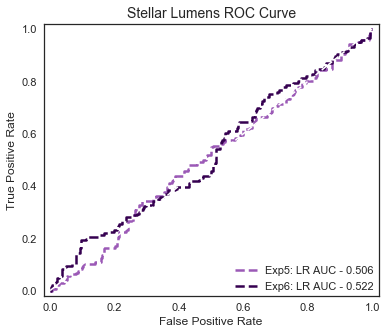

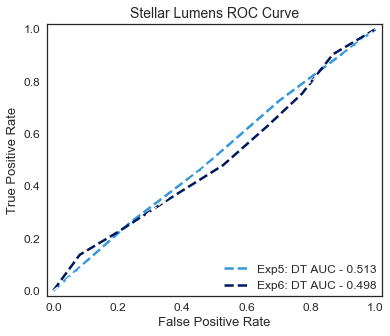

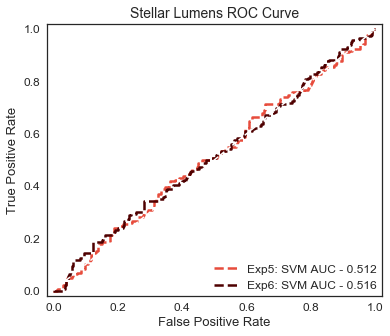

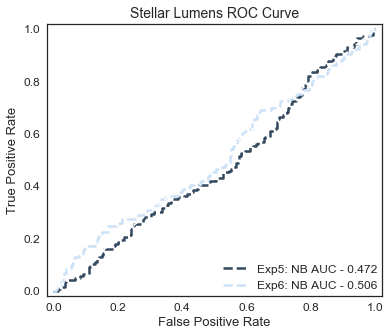

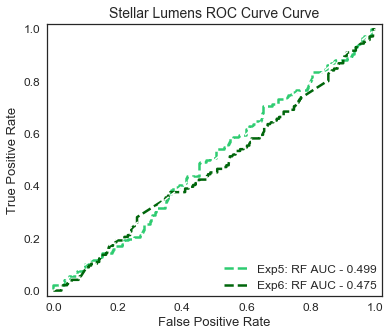

In [120]:
sns.set_style('white')
#ROC Curve
#line to show Logistic Regression
plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, linewidth= 2.5,linestyle='--', color = '#9b59b6', label='Exp5: LR AUC - %0.3f'% metrics.auc(fpr_lr, tpr_lr))
#line to show Logistic Regression
plt.plot(fpr_lr_no_tweet, tpr_lr_no_tweet, linewidth= 2.5,linestyle='--', color = '#350050', label='Exp6: LR AUC - %0.3f'% metrics.auc(fpr_lr_no_tweet, tpr_lr_no_tweet))
#ref line
plt.plot(fpr_lr_no_tweet, fpr_lr_no_tweet, linewidth= 1.5,linestyle='--', color = 'white')
#plot details
plt.legend( loc="lower right", borderaxespad=0. , fontsize=11)
plt.xlim(-0.02 , 1.02)
plt.ylim(-0.02 , 1.02)
plt.title('Stellar Lumens ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


plt.figure(figsize=(6,5))
#line to show Decision Tree
plt.plot(fpr_dt, tpr_dt, linewidth= 2.5,linestyle='--', color = '#3498db', label='Exp5: DT AUC - %0.3f'% metrics.auc(fpr_dt, tpr_dt))
#line to show Decision Tree
plt.plot(fpr_dt_no_tweet, tpr_dt_no_tweet, linewidth= 2.5,linestyle='--', color = '#00195C', label='Exp6: DT AUC - %0.3f'% metrics.auc(fpr_dt_no_tweet, tpr_dt_no_tweet))
#ref line
plt.plot(fpr_lr_no_tweet, fpr_lr_no_tweet, linewidth= 1.5,linestyle='--', color = 'white')
#plot details
plt.legend( loc="lower right", borderaxespad=0. , fontsize=12)
plt.xlim(-0.02 , 1.02)
plt.ylim(-0.02 , 1.02)
plt.title('Stellar Lumens ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


plt.figure(figsize=(6,5))
#line to show Support Vector Machine
plt.plot(fpr_svm, tpr_svm, linewidth= 2.5,linestyle='--', color = '#e74c3c', label='Exp5: SVM AUC - %0.3f'% metrics.auc(fpr_svm, tpr_svm))
#line to show Support Vector Machine
plt.plot(fpr_svm_no_tweet, tpr_svm_no_tweet, linewidth= 2.5,linestyle='--', color = '#4e0000', label='Exp6: SVM AUC - %0.3f'% metrics.auc(fpr_svm_no_tweet, tpr_svm_no_tweet))
#ref line
plt.plot(fpr_lr_no_tweet, fpr_lr_no_tweet, linewidth= 1.5,linestyle='--', color = 'white')
#plot details
plt.legend( loc="lower right", borderaxespad=0. , fontsize=12)
plt.xlim(-0.02 , 1.02)
plt.ylim(-0.02 , 1.02)
plt.title('Stellar Lumens ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


plt.figure(figsize=(6,5))
#line to show Naive Bayes
plt.plot(fpr_nb, tpr_nb, linewidth= 2.5,linestyle='--', color = '#34495e', label='Exp5: NB AUC - %0.3f'% metrics.auc(fpr_nb, tpr_nb))
#line to show Naive Bayes
plt.plot(fpr_nb_no_tweet, tpr_nb_no_tweet, linewidth= 2.5,linestyle='--', color = '#cde2f7', label='Exp6: NB AUC - %0.3f'% metrics.auc(fpr_nb_no_tweet, tpr_nb_no_tweet))
#ref line
plt.plot(fpr_lr_no_tweet, fpr_lr_no_tweet, linewidth= 1.5,linestyle='--', color = 'white')
#plot details
plt.legend( loc="lower right", borderaxespad=0. , fontsize=12)
plt.xlim(-0.02 , 1.02)
plt.ylim(-0.02 , 1.02)
plt.title('Stellar Lumens ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



plt.figure(figsize=(6,5))
#line to show Random Forest
plt.plot(fpr_rf, tpr_rf, linewidth= 2.5,linestyle='--', color = '#2ecc71', label='Exp5: RF AUC - %0.3f'% metrics.auc(fpr_rf, tpr_rf))
#line to show Random Forest
plt.plot(fpr_rf_no_tweet, tpr_rf_no_tweet, linewidth= 2.5,linestyle='--', color = '#00660b', label='Exp6: RF AUC - %0.3f'% metrics.auc(fpr_rf_no_tweet, tpr_rf_no_tweet))
#ref line
plt.plot(fpr_lr_no_tweet, fpr_lr_no_tweet, linewidth= 1.5,linestyle='--', color = 'white')
#plot details
plt.legend( loc="lower right", borderaxespad=0. , fontsize=12)
plt.xlim(-0.02 , 1.02)
plt.ylim(-0.02 , 1.02)
plt.title('Stellar Lumens ROC Curve Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Confusion Matrix

#### With Tweet Data

In [121]:
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(xlm_target_test, pred_model_lr).ravel()
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(xlm_target_test, pred_model_dt).ravel()
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(xlm_target_test, pred_model_svm).ravel()
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(xlm_target_test, pred_model_nb).ravel()
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(xlm_target_test, pred_model_rf).ravel()
print('Prevalence = %0.3f'%(sum(xlm_target_test)/len(xlm_target_test)))
print(' ')

print('Logistic Regression Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_lr))
print('TN: %d'%tn_lr, 'FP: %d'%fp_lr, 'FN: %d'%fn_lr, 'TP: %d'%tp_lr)
print (metrics.classification_report(xlm_target_test, pred_model_lr))

print('Decision Tree Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_dt))
print('TN: %d'%tn_dt, 'FP: %d'%fp_dt, 'FN: %d'%fn_dt, 'TP: %d'%tp_dt)
print (metrics.classification_report(xlm_target_test, pred_model_dt))

print('SVM Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_svm))
print('TN: %d'%tn_svm, 'FP: %d'%fp_svm, 'FN: %d'%fn_svm, 'TP: %d'%tp_svm)
print (metrics.classification_report(xlm_target_test, pred_model_svm))

print('Naive Bayes Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_nb[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_nb))
print('TN: %d'%tn_nb, 'FP: %d'%fp_nb, 'FN: %d'%fn_nb, 'TP: %d'%tp_nb)
print (metrics.classification_report(xlm_target_test, pred_model_nb))

print('Random Forest Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_rf))
print('TN: %d'%tn_rf, 'FP: %d'%fp_rf, 'FN: %d'%fn_rf, 'TP: %d'%tp_rf)
print (metrics.classification_report(xlm_target_test, pred_model_rf))

Prevalence = 0.342
 
Logistic Regression Model
ROC AUC: 0.506
Accuracy: 0.464
TN: 107 FP: 174 FN: 55 TP: 91
             precision    recall  f1-score   support

          0       0.66      0.38      0.48       281
          1       0.34      0.62      0.44       146

avg / total       0.55      0.46      0.47       427

Decision Tree Model
ROC AUC: 0.513
Accuracy: 0.445
TN: 84 FP: 197 FN: 40 TP: 106
             precision    recall  f1-score   support

          0       0.68      0.30      0.41       281
          1       0.35      0.73      0.47       146

avg / total       0.57      0.44      0.43       427

SVM Model
ROC AUC: 0.512
Accuracy: 0.658
TN: 281 FP: 0 FN: 146 TP: 0
             precision    recall  f1-score   support

          0       0.66      1.00      0.79       281
          1       0.00      0.00      0.00       146

avg / total       0.43      0.66      0.52       427

Naive Bayes Model
ROC AUC: 0.472
Accuracy: 0.607
TN: 238 FP: 43 FN: 125 TP: 21
             preci

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Without Tweet Data

In [130]:
tn_lr_no_tweet, fp_lr_no_tweet, fn_lr_no_tweet, tp_lr_no_tweet = confusion_matrix(xlm_target_test, pred_model_lr_no_tweet).ravel()
tn_dt_no_tweet, fp_dt_no_tweet, fn_dt_no_tweet, tp_dt_no_tweet = confusion_matrix(xlm_target_test, pred_model_dt_no_tweet).ravel()
tn_svm_no_tweet, fp_svm_no_tweet, fn_svm_no_tweet, tp_svm_no_tweet = confusion_matrix(xlm_target_test, pred_model_svm_no_tweet).ravel()
tn_nb_no_tweet, fp_nb_no_tweet, fn_nb_no_tweet, tp_nb_no_tweet = confusion_matrix(xlm_target_test, pred_model_nb_no_tweet).ravel()
tn_rf_no_tweet, fp_rf_no_tweet, fn_rf_no_tweet, tp_rf_no_tweet = confusion_matrix(xlm_target_test, pred_model_rf_no_tweet).ravel()
print('Prevalence = %0.3f'%(sum(xlm_target_test)/len(xlm_target_test)))
print(' ')

print('Logistic Regression Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_lr_no_tweet[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_lr_no_tweet))
print('TN: %d'%tn_lr_no_tweet, 'FP: %d'%fp_lr_no_tweet, 'FN: %d'%fn_lr_no_tweet, 'TP: %d'%tp_lr_no_tweet)
print (metrics.classification_report(xlm_target_test, pred_model_lr_no_tweet))

print('Decision Tree Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_dt_no_tweet[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_dt_no_tweet))
print('TN: %d'%tn_dt_no_tweet, 'FP: %d'%fp_dt_no_tweet, 'FN: %d'%fn_dt_no_tweet, 'TP: %d'%tp_dt_no_tweet)
print (metrics.classification_report(xlm_target_test, pred_model_dt_no_tweet))

print('SVM Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_svm_no_tweet[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_svm_no_tweet))
print('TN: %d'%tn_svm_no_tweet, 'FP: %d'%fp_svm_no_tweet, 'FN: %d'%fn_svm_no_tweet, 'TP: %d'%tp_svm_no_tweet)
print (metrics.classification_report(xlm_target_test, pred_model_svm_no_tweet))

print('Naive Bayes Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_nb_no_tweet[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_nb_no_tweet))
print('TN: %d'%tn_nb_no_tweet, 'FP: %d'%fp_nb_no_tweet, 'FN: %d'%fn_nb_no_tweet, 'TP: %d'%tp_nb_no_tweet)
print (metrics.classification_report(xlm_target_test, pred_model_nb_no_tweet))

print('Random Forest Model')
print('ROC AUC: %0.3f'%metrics.roc_auc_score(xlm_target_test, pred_probs_model_rf_no_tweet[:, 1]))
print('Accuracy: %0.3f'%metrics.accuracy_score(xlm_target_test, pred_model_rf_no_tweet))
print('TN: %d'%tn_rf_no_tweet, 'FP: %d'%fp_rf_no_tweet, 'FN: %d'%fn_rf_no_tweet, 'TP: %d'%tp_rf_no_tweet)
print (metrics.classification_report(xlm_target_test, pred_model_rf_no_tweet))

Prevalence = 0.342
 
Logistic Regression Model
ROC AUC: 0.522
Accuracy: 0.496
TN: 136 FP: 145 FN: 70 TP: 76
             precision    recall  f1-score   support

          0       0.66      0.48      0.56       281
          1       0.34      0.52      0.41       146

avg / total       0.55      0.50      0.51       427

Decision Tree Model
ROC AUC: 0.498
Accuracy: 0.475
TN: 133 FP: 148 FN: 76 TP: 70
             precision    recall  f1-score   support

          0       0.64      0.47      0.54       281
          1       0.32      0.48      0.38       146

avg / total       0.53      0.48      0.49       427

SVM Model
ROC AUC: 0.516
Accuracy: 0.658
TN: 281 FP: 0 FN: 146 TP: 0
             precision    recall  f1-score   support

          0       0.66      1.00      0.79       281
          1       0.00      0.00      0.00       146

avg / total       0.43      0.66      0.52       427

Naive Bayes Model
ROC AUC: 0.506
Accuracy: 0.651
TN: 275 FP: 6 FN: 143 TP: 3
             precisi

C:\Users\niall\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
